In [158]:
from os import sys
sys.path.append("/raid/MattC/repos/ProCogGraph/nextflow/bin/")
from utils import pdbe_sanitise_smiles
import pandas as pd

from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem import AllChem, MACCSkeys, PandasTools, rdFingerprintGenerator
from rdkit import Chem
from rdkit import DataStructs 
from rdkit.Chem import Draw
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import datasets, decomposition
from sklearn.manifold import TSNE
import matplotlib.cm as cm


pio.renderers.default = 'iframe'

from neo4j import __version__ as neo4j_version,  GraphDatabase
#class is adapted from https://towardsdatascience.com/neo4j-cypher-python-7a919a372be7
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None, **kwargs):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, **kwargs))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response
    
#connect to database
conn = Neo4jConnection(uri="bolt://localhost:7687", user="neo4j", pwd="yTJutYQ$$d%!9h")

In [161]:
db_path = "/raid/MattC/repos/ProCogGraphData/procoggraph_20240528" #this should be taken from the config file eventually
analysis_output_path = "/raid/MattC/repos/ProCogGraphData/analysis/notebooks/"

## Section 4.3.1 ProCogGraph Overview

In [371]:
process_structure_log = pd.read_csv("/raid/MattC/repos/ProCogGraphData/procoggraph_20240528/process_struct/process_mmcif_log.txt", sep = ",")
process_contacts_log = pd.read_csv("/raid/MattC/repos/ProCogGraphData/procoggraph_20240528/process_contacts/process_contacts_log.txt", sep = ",", names = ["pdb_id", "error_code", "status"])

process_structure_log.rename(columns = {"error_code": "mmcif_status"}, inplace = True)
process_contacts_log.rename(columns = {"error_code": "contacts_status"}, inplace = True)

process_structure_log.loc[process_structure_log.mmcif_status == 122, "error_message"] = "No bound entities in assembly"
process_structure_log.loc[process_structure_log.mmcif_status == 120, "error_message"] = "CIF Formatting Error"
process_structure_log.loc[process_structure_log.mmcif_status == 0, "error_message"] = "Contains bound entity"
process_contacts_log.loc[process_contacts_log.status == "no_domains_over_contact_cutoff", "status"] = "No contacts above cutoff (min 3 contacts)"
process_contacts_log.loc[process_contacts_log.status == "no_domains_in_assembly", "status"] = "No domains present in assembly."
process_contacts_log.loc[process_contacts_log.status == "no_contacts_record", "status"] = "Arpeggio Timeout"
process_contacts_log.loc[process_contacts_log.status == "arpeggio_failure", "status"] = "Arpeggio Failure"
process_contacts_log.loc[process_contacts_log.status == "no_valid_ligand_protein_contacts", "status"] = "No contacts between entity and domain"
process_contacts_log.loc[process_contacts_log.status == "no_ligand_domain_contacts", "status"] = "No contacts between entity and domain"
process_contacts_log.loc[process_contacts_log.status == "no_ligand_protein_contacts", "status"] = "No contacts between entity and domain"
process_contacts_log.loc[process_contacts_log.status == "success", "status"] = "Contacts annotated"

process_contacts_log_simple = process_contacts_log.copy()
process_contacts_log_simple.loc[process_contacts_log_simple.status.isin(["CIF Formatting Error", "No contacts above cutoff (min 3 contacts)", "Arpeggio Timeout", "No domains present in assembly.", "Arpeggio Failure", "No contacts between entity and domain"]), "status"] = "Not Processed"

#we need a set of nodes and a set of links.
nodes0 = pd.DataFrame({"node": ["SIFTS"], "count": sifts.PDB.nunique()})
nodes1 = pd.DataFrame({"node": ["Contains EC Annotation", "No EC Annotation"], "count": [process_structure_log.pdb_id.nunique(), sifts.PDB.nunique() - process_structure_log.pdb_id.nunique()]})
nodes2 = process_structure_log.error_message.value_counts().reset_index().rename(columns = {"error_message": "node"})
nodes3 = process_contacts_log_simple.status.value_counts().reset_index().rename(columns = {"status": "node"})

nodes = pd.concat([nodes0, nodes1, nodes2, nodes3], ignore_index = True).reset_index()
links = {"source": [0,0,1,1,1,3,3],
         "target": [2,1,3,4,5,6,7],
         "value": [89234, 114411,98567,15843,1,96375,4963]}

fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.5),
      label =  nodes["node"] + " (" + nodes["count"].astype("str") + ")",
    ),
    # Add links
    link = links,
    orientation = "h")])

fig.update_layout(title_text="Annotation of structures in the PDB using ProCogGraph",
                  font_size=8)

pio.write_image(fig, f'{analysis_output_path}/figures/pipeline/pipeline_processing_raw.svg',scale=6)

In [ ]:
sifts = pd.read_csv("/raid/MattC/repos/ProCogGraphData/data_files/pdb_chain_enzyme.tsv.gz", skiprows = 1, sep = "\t")
sifts.loc[sifts.EC_NUMBER != "?"].PDB.nunique()

In [ ]:
cath_domains = pd.read_csv(f"/raid/MattC/repos/ProCogGraphData/procoggraph_20240528/contacts/cath_pdb_residue_interactions.csv.gz", na_values = ["NaN", "None"], keep_default_na = False, dtype = {"bound_ligand_residue_interactions":"str", "bound_entity_pdb_residues": "str", "cath_architecture": "str", "cath_class": "str", "cath_topology": "str", "cath_homologous_superfamily": "str"}, sep = "\t")
scop_domains = pd.read_csv(f"/raid/MattC/repos/ProCogGraphData/procoggraph_20240528/contacts/scop_pdb_residue_interactions.csv.gz", na_values = ["NaN", "None"], keep_default_na = False, dtype = {"bound_ligand_residue_interactions":"str", "bound_entity_pdb_residues": "str"}, sep = "\t")
pfam_domains = pd.read_csv(f"/raid/MattC/repos/ProCogGraphData/procoggraph_20240528/contacts/pfam_pdb_residue_interactions.csv.gz", na_values = ["NaN", "None"], keep_default_na = False, dtype = {"bound_ligand_residue_interactions":"str", "bound_entity_pdb_residues": "str"}, sep = "\t")
superfamily_domains =pd.read_csv(f"/raid/MattC/repos/ProCogGraphData/procoggraph_20240528/contacts/superfamily_pdb_residue_interactions.csv.gz", na_values = ["NaN", "None"], keep_default_na = False, dtype = {"bound_ligand_residue_interactions":"str", "bound_entity_pdb_residues": "str"}, sep = "\t")
gene3dsa_domains = pd.read_csv(f"/raid/MattC/repos/ProCogGraphData/procoggraph_20240528/contacts/gene3dsa_pdb_residue_interactions.csv.gz", na_values = ["NaN", "None"], keep_default_na = False, dtype = {"bound_ligand_residue_interactions":"str", "bound_entity_pdb_residues": "str", "cath_architecture": "str", "cath_class": "str", "cath_topology": "str", "cath_homologous_superfamily": "str"}, sep = "\t")
scop2_sf_domains = pd.read_csv(f"/raid/MattC/repos/ProCogGraphData/procoggraph_20240528/contacts/scop2_sf_pdb_residue_interactions.csv.gz", na_values = ["NaN", "None"], keep_default_na = False, dtype = {"bound_ligand_residue_interactions":"str", "bound_entity_pdb_residues": "str"}, sep = "\t")
scop2_sf_domains["SCOPCLA"] = scop2_sf_domains.SCOPCLA.str.split(";")
scop2_sf_domains = scop2_sf_domains.explode("SCOPCLA")
scop2_sf_domains[["TP", "CL", "CF", "SF"]] = scop2_sf_domains.SCOPCLA.str.split(",", expand = True)
scop2_sf_domains["TP"] = scop2_sf_domains["TP"].str.replace("TP=", "")
scop2_sf_domains["CL"] = scop2_sf_domains["CL"].str.replace("CL=", "")
scop2_sf_domains["CF"] = scop2_sf_domains["CF"].str.replace("CF=", "")
scop2_sf_domains["SF"] = scop2_sf_domains["SF"].str.replace("SF=", "")

scop2_fa_domains = pd.read_csv(f"/raid/MattC/repos/ProCogGraphData/procoggraph_20240528/contacts/scop2_fa_pdb_residue_interactions.csv.gz", na_values = ["NaN", "None"], keep_default_na = False, dtype = {"bound_ligand_residue_interactions":"str", "bound_entity_pdb_residues": "str"}, sep = "\t")
scop2_fa_domains["SCOPCLA"] = scop2_fa_domains.SCOPCLA.str.split(";")
scop2_fa_domains = scop2_fa_domains.explode("SCOPCLA")
scop2_fa_domains[["TP", "CL", "CF", "SF", "FA"]] = scop2_fa_domains.SCOPCLA.str.split(",", expand = True)
scop2_fa_domains["TP"] = scop2_fa_domains["TP"].str.replace("TP=", "")
scop2_fa_domains["CL"] = scop2_fa_domains["CL"].str.replace("CL=", "")
scop2_fa_domains["CF"] = scop2_fa_domains["CF"].str.replace("CF=", "")
scop2_fa_domains["SF"] = scop2_fa_domains["SF"].str.replace("SF=", "")
scop2_fa_domains["FA"] = scop2_fa_domains["FA"].str.replace("FA=", "")

In [182]:
bound_entities_with_coglig = """
MATCH (c:cathDomain)-[int:INTERACTS_WITH_LIGAND]->(be:boundEntity)-[sim:HAS_SIMILARITY]->(bl:cognateLigand)
WHERE sim.parityScore >= toFloat($parity_score_cutoff) AND sim.bestCognate = "Y"
RETURN COUNT(DISTINCT(be.uniqueID)) as num_be_uniqueids, COUNT(DISTINCT(bl.uniqueID)) as num_bl_unique_ids, "CATH" as type, $parity_score_cutoff as cutoff
UNION
MATCH (c:scopDomain)-[int:INTERACTS_WITH_LIGAND]->(be:boundEntity)-[sim:HAS_SIMILARITY]->(bl:cognateLigand)
WHERE sim.parityScore >= toFloat($parity_score_cutoff) AND sim.bestCognate = "Y"
RETURN COUNT(DISTINCT(be.uniqueID)) as num_be_uniqueids, COUNT(DISTINCT(bl.uniqueID)) as num_bl_unique_ids, "SCOP" as type, $parity_score_cutoff as cutoff
UNION
MATCH (c:pfamDomain)-[int:INTERACTS_WITH_LIGAND]->(be:boundEntity)-[sim:HAS_SIMILARITY]->(bl:cognateLigand)
WHERE sim.parityScore >= toFloat($parity_score_cutoff) AND sim.bestCognate = "Y"
RETURN COUNT(DISTINCT(be.uniqueID)) as num_be_uniqueids, COUNT(DISTINCT(bl.uniqueID)) as num_bl_unique_ids, "Pfam" as type, $parity_score_cutoff as cutoff
UNION
MATCH (c:superfamilyDomain)-[int:INTERACTS_WITH_LIGAND]->(be:boundEntity)-[sim:HAS_SIMILARITY]->(bl:cognateLigand)
WHERE sim.parityScore >= toFloat($parity_score_cutoff) AND sim.bestCognate = "Y"
RETURN COUNT(DISTINCT(be.uniqueID)) as num_be_uniqueids, COUNT(DISTINCT(bl.uniqueID)) as num_bl_unique_ids, "SUPERFAMILY" as type, $parity_score_cutoff as cutoff
UNION
MATCH (c:gene3dDomain)-[int:INTERACTS_WITH_LIGAND]->(be:boundEntity)-[sim:HAS_SIMILARITY]->(bl:cognateLigand)
WHERE sim.parityScore >= toFloat($parity_score_cutoff) AND sim.bestCognate = "Y"
RETURN COUNT(DISTINCT(be.uniqueID)) as num_be_uniqueids, COUNT(DISTINCT(bl.uniqueID)) as num_bl_unique_ids, "Gene3D" as type, $parity_score_cutoff as cutoff
UNION
MATCH (c:scop2sfDomain)-[int:INTERACTS_WITH_LIGAND]->(be:boundEntity)-[sim:HAS_SIMILARITY]->(bl:cognateLigand)
WHERE sim.parityScore >= toFloat($parity_score_cutoff) AND sim.bestCognate = "Y"
RETURN COUNT(DISTINCT(be.uniqueID)) as num_be_uniqueids, COUNT(DISTINCT(bl.uniqueID)) as num_bl_unique_ids, "SCOP2" as type, $parity_score_cutoff as cutoff
"""


bound_entities_with_coglig_result_04 = pd.DataFrame([dict(_) for _ in conn.query(query = bound_entities_with_coglig, db='neo4j', parity_score_cutoff=0.4)])

In [193]:
cath_db_info = pd.DataFrame([{"type": "CATH", 
  "PDB Entries": cath_domains.pdb_id.nunique(),
  "Num Groups": cath_domains.cath_homologous_superfamily.nunique(),
  "EC numbers (only absolutely defined)": cath_domains.loc[~cath_domains.protein_entity_ec.str.contains('-')].ec_list.str.split(',').explode().nunique(),
  "EC Numbers (including expanded partial)": cath_domains.ec_list.str.split(',').explode().nunique(),
  "Ligands In Database" : cath_domains.uniqueID.nunique(),
  "Ligands with Mapping (0.4 cutoff)": bound_entities_with_coglig_result_04.loc[bound_entities_with_coglig_result_04.type == "CATH", "num_be_uniqueids"].values[0],
  "Number of cognate ligands mapped" : bound_entities_with_coglig_result_04.loc[bound_entities_with_coglig_result_04.type == "CATH", "num_bl_unique_ids"].values[0]
 }])


scop_db_info = pd.DataFrame([{"type": "SCOP", 
  "PDB Entries": scop_domains.pdb_id.nunique(),
  "Num Groups": scop_domains.superfamily_sccs.nunique(),
  "EC numbers (only absolutely defined)": scop_domains.loc[~scop_domains.protein_entity_ec.str.contains('-')].ec_list.str.split(',').explode().nunique(),
  "EC Numbers (including expanded partial)": scop_domains.ec_list.str.split(',').explode().nunique(),
  "Ligands In Database" : scop_domains.uniqueID.nunique(),
  "Ligands with Mapping (0.4 cutoff)": bound_entities_with_coglig_result_04.loc[bound_entities_with_coglig_result_04.type == "SCOP", "num_be_uniqueids"].values[0],
  "Number of cognate ligands mapped": bound_entities_with_coglig_result_04.loc[bound_entities_with_coglig_result_04.type == "SCOP", "num_bl_unique_ids"].values[0]
 }])

pfam_db_info = pd.DataFrame([{"type": "Pfam", 
  "PDB Entries": pfam_domains.pdb_id.nunique(),
  "Num Groups": pfam_domains.pfam_accession.nunique(),
  "EC numbers (only absolutely defined)": pfam_domains.loc[~pfam_domains.protein_entity_ec.str.contains('-')].ec_list.str.split(',').explode().nunique(),
  "EC Numbers (including expanded partial)": pfam_domains.ec_list.str.split(',').explode().nunique(),
  "Ligands In Database" : pfam_domains.uniqueID.nunique(),
  "Ligands with Mapping (0.4 cutoff)": bound_entities_with_coglig_result_04.loc[bound_entities_with_coglig_result_04.type == "Pfam", "num_be_uniqueids"].values[0],
  "Number of cognate ligands mapped": bound_entities_with_coglig_result_04.loc[bound_entities_with_coglig_result_04.type == "Pfam", "num_bl_unique_ids"].values[0]
 }])

superfamily_db_info = pd.DataFrame([{"type": "SUPERFAMILY", 
  "PDB Entries": superfamily_domains.pdb_id.nunique(),
  "Num Groups": superfamily_domains.superfamily_sccs.nunique(),
  "EC numbers (only absolutely defined)": superfamily_domains.loc[~superfamily_domains.protein_entity_ec.str.contains('-')].ec_list.str.split(',').explode().nunique(),
  "EC Numbers (including expanded partial)": superfamily_domains.ec_list.str.split(',').explode().nunique(),
  "Ligands In Database" : superfamily_domains.uniqueID.nunique(),
  "Ligands with Mapping (0.4 cutoff)": bound_entities_with_coglig_result_04.loc[bound_entities_with_coglig_result_04.type == "SUPERFAMILY", "num_be_uniqueids"].values[0],
  "Number of cognate ligands mapped": bound_entities_with_coglig_result_04.loc[bound_entities_with_coglig_result_04.type == "SUPERFAMILY", "num_bl_unique_ids"].values[0]
 }])

gene3d_db_info = pd.DataFrame([{"type": "Gene3D", 
  "PDB Entries": gene3dsa_domains.pdb_id.nunique(),
  "Num Groups": gene3dsa_domains.cath_homologous_superfamily.nunique(),
  "EC numbers (only absolutely defined)": gene3dsa_domains.loc[~gene3dsa_domains.protein_entity_ec.str.contains('-')].ec_list.str.split(',').explode().nunique(),
  "EC Numbers (including expanded partial)": gene3dsa_domains.ec_list.str.split(',').explode().nunique(),
  "Ligands In Database" : gene3dsa_domains.uniqueID.nunique(),
  "Ligands with Mapping (0.4 cutoff)": bound_entities_with_coglig_result_04.loc[bound_entities_with_coglig_result_04.type == "Gene3D", "num_be_uniqueids"].values[0],
  "Number of cognate ligands mapped": bound_entities_with_coglig_result_04.loc[bound_entities_with_coglig_result_04.type == "Gene3D", "num_bl_unique_ids"].values[0]
 }])

scop2_db_info = pd.DataFrame([{"type": "SCOP2", 
  "PDB Entries": scop2_sf_domains.pdb_id.nunique(),
  "Num Groups": scop2_sf_domains.SF.nunique(),
  "EC numbers (only absolutely defined)": scop2_sf_domains.loc[~scop2_sf_domains.protein_entity_ec.str.contains('-')].ec_list.str.split(',').explode().nunique(),
  "EC Numbers (including expanded partial)": scop2_sf_domains.ec_list.str.split(',').explode().nunique(),
  "Ligands In Database" : scop2_sf_domains.uniqueID.nunique(),
  "Ligands with Mapping (0.4 cutoff)": bound_entities_with_coglig_result_04.loc[bound_entities_with_coglig_result_04.type == "SCOP2", "num_be_uniqueids"].values[0],
  "Number of cognate ligands mapped": bound_entities_with_coglig_result_04.loc[bound_entities_with_coglig_result_04.type == "SCOP2", "num_bl_unique_ids"].values[0]
 }])

db_info_df = pd.concat([cath_db_info, scop_db_info, pfam_db_info, superfamily_db_info, gene3d_db_info, scop2_db_info]).T

db_info_df.to_csv(f"{analysis_output_path}/tables/procoggraph_db_summary.csv")

In [195]:
db_info_df

,0,0,0,0,0,0
type,CATH,SCOP,Pfam,SUPERFAMILY,Gene3D,SCOP2
PDB Entries,61473,17166,89805,74473,60500,64945
Num Groups,1907,762,3960,874,1148,1054
EC numbers (only absolutely defined),2831,1694,3282,2775,2435,2292
EC Numbers (including expanded partial),6652,6313,6689,6651,6648,6606
Ligands In Database,297547,76446,433442,359828,293741,309522
Ligands with Mapping (0.4 cutoff),104449,28823,151529,125909,102807,101297
Number of cognate ligands mapped,2296,1189,2710,2340,2098,2114


## Section 4.3.2.1 Ligands Without Mapping

To begin, lets look at the worst possible aspect of ProCogGraph - cases where we are unable to match a cognate ligand.

The code below focusses on the bound descriptors with NO cognate ligand mappings at all, and can be seen to contain many typical buffer components e.g. salt ions and lipids.

In [6]:
bd_no_coglig_query = """
MATCH (bd:boundDescriptor)<-[:DESCRIBED_BY]-(be:boundEntity)
WHERE NOT (be)-[:HAS_SIMILARITY]->(:cognateLigand)
AND NOT EXISTS {
  MATCH (bd)<-[:DESCRIBED_BY]-(be2:boundEntity)-[:HAS_SIMILARITY]->(:cognateLigand)
}
RETURN DISTINCT bd.uniqueID, bd.name, bd.descriptor, bd.description, COUNT(DISTINCT be.uniqueID) as count_be
ORDER BY count_be DESC
"""

bd_no_coglig_query_result = pd.DataFrame(conn.query(query = bd_no_coglig_query, db='neo4j'), columns = ["ligandUniqueID", "ligandName", "ligandDescriptor", "ligandDescription", "numBoundEntities"])

print(f"""Ten most underrepresented PDB ligands account for {bd_no_coglig_query_result.head(10).numBoundEntities.sum()/bd_no_coglig_query_result.numBoundEntities.sum()}% of all BE occurneces of unmatched ligands""")

bd_no_coglig_query_result.head(10).to_csv("top10_no_coglig_match.csv", index = False)

bd_any_coglig_query = """
MATCH (n:boundEntity)-[:HAS_SIMILARITY]->(cl:cognateLigand) 
RETURN COUNT(DISTINCT(n.ligandUniqueID)) as numEntities, "numBoundDescriptorsWithCoglig" as type
UNION
MATCH (n:boundDescriptor) RETURN COUNT(DISTINCT(n.uniqueID)) as numEntities, "totalBoundDescriptors" as type"""
bd_any_coglig_query_result = pd.DataFrame(conn.query(query = bd_any_coglig_query, db='neo4j'), columns = ["numEntities", "type"])

bd_any_coglig_query_result_t = bd_any_coglig_query_result.set_index("type").T
bd_any_coglig_query_result_t["perc"] = bd_any_coglig_query_result_t.numBoundDescriptorsWithCoglig/bd_any_coglig_query_result_t.totalBoundDescriptors

bd_any_coglig_query_result_t

Ten most underrepresented PDB ligands account for 0.07894644053453687% of all BE occurneces of unmatched ligands


type,numBoundDescriptorsWithCoglig,totalBoundDescriptors,perc
numEntities,7408,29635,0.249975


In [8]:
bd_no_coglig_query_result["ROMol"] = bd_no_coglig_query_result["ligandDescriptor"].apply(lambda x: pdbe_sanitise_smiles(x, return_mol = True))  

[11:42:49] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[11:42:49] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


In [197]:
bd_no_coglig_query_result.head(10)

,ligandUniqueID,ligandName,ligandDescriptor,ligandDescription,numBoundEntities,ROMol
0,10876,CLA,O=C(OC)C1C(=O)C2=C(C)C3=CC=4C(CC)=C(C)C5=Cc6c(...,CHLOROPHYLL A,1102,<rdkit.Chem.rdchem.Mol object at 0x7f4415b77d10>
1,10678,CD,[Cd+2],CADMIUM ION,642,<rdkit.Chem.rdchem.Mol object at 0x7f4415b77ae0>
2,21350,PC1,O=C(OC(COP([O-])(=O)OCC[N+](C)(C)C)COC(=O)CCCC...,"1,2-DIACYL-SN-GLYCERO-3-PHOSPHOCHOLINE",537,<rdkit.Chem.rdchem.Mol object at 0x7f4415b77a00>
3,3250,3PE,NCCOP(O)(=O)OCC(COC(=O)CCCCCCCCCCCCCCCCC)OC(=O...,"1,2-DIACYL-SN-GLYCERO-3-PHOSPHOETHANOLAMINE",428,<rdkit.Chem.rdchem.Mol object at 0x7f4415b77920>
4,9869,BEF,F[Be-](F)F,BERYLLIUM TRIFLUORIDE ION,409,<rdkit.Chem.rdchem.Mol object at 0x7f4415b77530>
5,21581,PLX,O=P(OCC(OC(O)CCCCCCCCCCCCCCCCC)COC(O)CCCCCCCCC...,"(9R,11S)-9-({[(1S)-1-HYDROXYHEXADECYL]OXY}METH...",366,<rdkit.Chem.rdchem.Mol object at 0x7f4415b77b50>
6,21413,PEK,O=C(OCC(OC(=O)CCC\C=C/C\C=C/C\C=C/C\C=C/CCCCC)...,(1S)-2-{[(2-AMINOETHOXY)(HYDROXY)PHOSPHORYL]OX...,262,<rdkit.Chem.rdchem.Mol object at 0x7f4415b77370>
7,25607,TGL,O=C(OCC(OC(=O)CCCCCCCCCCCCCCCCC)COC(=O)CCCCCCC...,TRISTEAROYLGLYCEROL,260,<rdkit.Chem.rdchem.Mol object at 0x7f4415b77c30>
8,9148,ALF,F[Al-](F)(F)F,TETRAFLUOROALUMINATE ION,245,<rdkit.Chem.rdchem.Mol object at 0x7f4415b77ca0>
9,11074,CUA,[Cu][Cu],DINUCLEAR COPPER ION,227,<rdkit.Chem.rdchem.Mol object at 0x7f4415b77990>


In [198]:
#get svgs of the structures of the top 10 to add to paper table
for _,row in bd_no_coglig_query_result.head(10).iterrows():
    Draw.MolToFile(row.ROMol, f'{analysis_output_path}/figures/unmapped_pdb_ligand_structures/{row.ligandName}.svg', format='svg')

### 4.3.2.2 The Cognate Ligand Chemical Space

In [200]:
cognate_ligand_breakdown_query = """
MATCH (be:boundEntity) RETURN count(distinct(be.uniqueID)) as num, "total_bound_entities" as type
UNION
MATCH (be:boundEntity)-[sim:HAS_SIMILARITY]-(cl:cognateLigand) WHERE sim.parityScore >= toFloat($parity_score_cutoff) AND sim.bestCognate = "Y" WITH be, sim, cl ORDER BY sim.parityScore DESC WITH be, head(collect(sim)) AS firstSim, head(collect(cl)) AS firstCl RETURN count(distinct(be.uniqueID)) as num, "bound_entities_bestcognate_and_above_cutoff" as type
UNION
MATCH (be:boundEntity)-[sim:HAS_SIMILARITY]-(cl:cognateLigand) WITH be, sim, cl ORDER BY sim.parityScore DESC WITH be, sim, cl ORDER BY sim.parityScore DESC WITH be, head(collect(sim)) AS firstSim, head(collect(cl)) AS firstCl WHERE firstSim.parityScore = 1 AND firstSim.bestCognate = "Y" RETURN count(distinct(be.uniqueID)) as num, "total perfect match" as type
"""

cognate_ligand_breakdown_query_result = pd.DataFrame([dict(_) for _ in conn.query(query = cognate_ligand_breakdown_query, db='neo4j', parity_score_cutoff=0.4)])
cognate_ligand_breakdown_query_result

,num,type
0,489661,total_bound_entities
1,168314,bound_entities_bestcognate_and_above_cutoff
2,73358,total perfect match


In [201]:
#breakdown of the cofactors:

cofactor_breakdown_query = """
MATCH (be:boundEntity)-[sim:HAS_SIMILARITY]-(cl:cognateLigand) WITH be, sim, cl ORDER BY sim.parityScore DESC WITH be, head(collect(sim)) AS firstSim, head(collect(cl)) AS firstCl WHERE firstSim.parityScore = 1 AND firstSim.bestCognate = "Y" and firstCl.isCofactor <> "N" RETURN DISTINCT firstCl.name as name, firstCl.isCofactor as type, count(distinct(be.uniqueID)) as num_be ORDER BY type, num_be DESC
UNION
MATCH (be:boundEntity)-[sim:HAS_SIMILARITY]-(cl:cognateLigand) WITH be, sim, cl ORDER BY sim.parityScore DESC WITH be, head(collect(sim)) AS firstSim, head(collect(cl)) AS firstCl WHERE firstSim.parityScore = 1 AND firstSim.bestCognate = "Y" and firstCl.isCofactor = "N" RETURN DISTINCT firstCl.name as name, "Substrate/Product" as type, count(distinct(be.uniqueID)) as num_be ORDER BY type, num_be DESC
"""
cofactor_breakdown_query_result = pd.DataFrame(conn.query(query = cofactor_breakdown_query, db='neo4j'))
cofactor_breakdown_query_result.columns = ["names", "type", "be_count"]

cofactor_breakdown_query_result["name"] =  cofactor_breakdown_query_result["names"].apply(lambda x: min(x, key=len))
cofactor_breakdown_query_result.drop(columns = ["names"], inplace = True)

manual_cofactor_names = ["GTP", "GDP", "ADP", "CoA"] #we manually annotate some ligands to be cofactors despite their absence from ChEBI
cofactor_breakdown_query_result.loc[cofactor_breakdown_query_result.name.isin(manual_cofactor_names), "type"] = "Cofactor"

cofactor_breakdown_query_result["group"] = cofactor_breakdown_query_result["name"]
cofactor_breakdown_query_result.loc[cofactor_breakdown_query_result.name.isin(["NADP+", "NAD+", "NADH", "NADPH"]), "group"] = "NAD/NADP"
cofactor_breakdown_query_result.loc[cofactor_breakdown_query_result.name.isin(["ATP", "ADP", "AMP"]), "group"] = "ATP/ADP/AMP"
cofactor_breakdown_query_result.loc[cofactor_breakdown_query_result.name.isin(["GTP", "GDP", "GMP"]), "group"] = "GTP/GDP/GMP"
cofactor_breakdown_query_result.loc[cofactor_breakdown_query_result.name.isin(["Fe3+", "Fe2+", "Fe+", "Cu2+", "Cu+", "Ca2+", "Zn2+", "Mg2+", "K+[side 1]", "Co2+", "Mn2+", "Ni2+"]), "group"] = "Metals (Fe, Cu, Ca, Zn, Mg, K, Co, Mn, Ni)"
                                    
cofactor_breakdown_query_result_grouped = cofactor_breakdown_query_result.groupby("group").agg({"type":"first", "be_count":"sum"}).reset_index()
## aggregate top 5 and then rest into others, for each group
## from https://stackoverflow.com/questions/67720054/how-to-select-top-n-of-two-groups-and-aggregate-the-rest-of-the-second-group-int

ligand_top_10 = cofactor_breakdown_query_result_grouped.groupby('type').apply(lambda x: x.nlargest(10, 'be_count')).reset_index(drop=True)
ligand_others_10 = pd.concat([cofactor_breakdown_query_result_grouped, cofactor_breakdown_query_result_grouped.merge(ligand_top_10,'inner')]).drop_duplicates(keep=False)
ligand_others_10 = ligand_others_10.groupby('type')['be_count'].sum().reset_index()
ligand_others_10['name'] = 'other'
ligand_others_10['group'] = 'other'

ligand_all_10 = pd.concat([ligand_top_10,ligand_others_10]).sort_values(["type", "be_count"]).reset_index(drop=True)

/tmp/ipykernel_1895153/3476869382.py:27: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [202]:
ligand_all_10.groupby("type").agg({"be_count":"sum"})

,be_count
type,
Coenzyme,1382
Coenzyme/Cofactor/Prosthetic Group,45
Cofactor,41945
Prosthetic Group,50
Substrate/Product,29936


for chemical simialrity analysis, we will use an MACCSKey fingerprint. we calculate this for all of our ligands of interest , and then build a dissimilarity matrix using a pairwise tanimoto similarity.

In [203]:
superfamily_cogligs_query = """
MATCH (cl:cognateLigand)<-[sim:HAS_SIMILARITY {bestCognate: "Y"}]-(be:boundEntity)<-[int:INTERACTS_WITH_LIGAND]-(d:cathDomain)-[:IS_IN_CATH_HOMOLOGOUS_SUPERFAMILY]->(ch:cathHomologousSuperfamily)
WHERE sim.parityScore >= 0.4 AND int.interactionMode <> "minor"
RETURN ch.cathHomologousSuperfamily as chs, ch.description as chs_desc, COLLECT(DISTINCT([cl.canonicalSMILES, cl.name[0], cl.isCofactor])) as coglig_smiles,  COLLECT(DISTINCT(be.ecList)) as ecList
"""

superfamily_cogligs_query_result = pd.DataFrame(conn.query(query = superfamily_cogligs_query, db='neo4j'), columns = ["chs", "chs_desc", "coglig_smiles", "ecList"])
superfamily_cogligs_query_result_exploded = superfamily_cogligs_query_result.explode("coglig_smiles")
superfamily_cogligs_query_result_exploded[["coglig_smiles", "coglig_name", "cofactor"]] = superfamily_cogligs_query_result_exploded.coglig_smiles.apply(pd.Series)
superfamily_cogligs_query_result_exploded["ROMol"] = superfamily_cogligs_query_result_exploded.coglig_smiles.apply(lambda x: pdbe_sanitise_smiles(x, return_mol = True))
superfamily_cogligs_query_result_exploded["MACCSKey"] = superfamily_cogligs_query_result_exploded.ROMol.apply(lambda x: MACCSkeys.GenMACCSKeys(x))

superfamily_cogligs_query_result_exploded_unique_ligs = superfamily_cogligs_query_result_exploded[["coglig_name", "MACCSKey"]].drop_duplicates(subset = ["coglig_name"]).copy()

#we use a global t-sne of all cogligs in the exploded df to investigate clustering of similar and different ligands.

tsne = TSNE(n_components=2, perplexity=24, max_iter=5000, random_state = 42)
tsne_result = tsne.fit_transform(np.array(superfamily_cogligs_query_result_exploded_unique_ligs.MACCSKey.tolist()))
superfamily_cogligs_query_result_exploded_unique_ligs['t-SNE 1'] = tsne_result[:, 0]
superfamily_cogligs_query_result_exploded_unique_ligs['t-SNE 2'] = tsne_result[:, 1]

superfamily_cogligs_query_result_exploded_unique_ligs.drop(columns = ["MACCSKey"], inplace = True)

superfamily_cogligs_query_result_exploded = superfamily_cogligs_query_result_exploded.merge(superfamily_cogligs_query_result_exploded_unique_ligs, on = "coglig_name")

#measure the intra-homol superfam diversity for each domain. find the top 10 most and least diverse domains. Least diverse are HIGHLY SPECIALISED , MOST DIVERSE ARE HIGHLY GENERALISED.
def tanimoto_distance_matrix(fp_list):
    #FROM https://projects.volkamerlab.org/teachopencadd/talktorials/T005_compound_clustering.html
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([x for x in similarities])
    return dissimilarity_matrix

def intra_group_mean_and_std(fp_array):
    """Calculate the group mean and std from triangular dissimilarity matrix"""
    dis = tanimoto_distance_matrix(fp_array)
    mean = np.mean(dis)
    std = np.std(dis)
    num_fp = len(fp_array)
    return [num_fp, mean, std]

superfamily_cogligs_query_mean_std = superfamily_cogligs_query_result_exploded.groupby(["chs", "chs_desc"]).MACCSKey.apply(lambda x: intra_group_mean_and_std(x.values)).reset_index()
superfamily_cogligs_query_mean_std[["num_cogligs","sim_mean", "sim_std"]] = superfamily_cogligs_query_mean_std.MACCSKey.apply(pd.Series)
superfamily_cogligs_query_mean_std.drop(columns = ["MACCSKey"], inplace = True)
superfamily_cogligs_query_mean_std_low = superfamily_cogligs_query_mean_std.loc[superfamily_cogligs_query_mean_std.num_cogligs <= 3].sort_values("sim_mean", ascending = False).reset_index(drop = True)
superfamily_cogligs_query_mean_std_multi = superfamily_cogligs_query_mean_std.loc[superfamily_cogligs_query_mean_std.num_cogligs > 3].sort_values("sim_mean", ascending = False).reset_index(drop = True)

/home/twr_w20032671/miniconda3/envs/procoggraph/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/home/twr_w20032671/miniconda3/envs/procoggraph/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide

/home/twr_w20032671/miniconda3/envs/procoggraph/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/twr_w20032671/miniconda3/envs/procoggraph/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning:

invalid value encountered in divide

/home/twr_w20032671/miniconda3/envs/procoggraph/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning:

invalid value encountered in scalar divide



In [204]:
#first get a df of t-sne ordinations for all cogligs that can be merged with results to plot.
coglig_tsne = superfamily_cogligs_query_result_exploded[["coglig_name", "t-SNE 1", "t-SNE 2"]].drop_duplicates("coglig_name")

In [205]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 ,13 , 14, 15, 16,17, 18,19,20,21,22,23] # To explore the "best" number of cluster to clasify our molecules
X = coglig_tsne[["t-SNE 1", "t-SNE 2"]].values
for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

For n_clusters = 2 The average silhouette_score is : 0.38697913
For n_clusters = 3 The average silhouette_score is : 0.4019957
For n_clusters = 4 The average silhouette_score is : 0.42118546
For n_clusters = 5 The average silhouette_score is : 0.45344368
For n_clusters = 6 The average silhouette_score is : 0.43290257
For n_clusters = 7 The average silhouette_score is : 0.45380482
For n_clusters = 8 The average silhouette_score is : 0.45724812
For n_clusters = 9 The average silhouette_score is : 0.43814632
For n_clusters = 10 The average silhouette_score is : 0.4522633
For n_clusters = 11 The average silhouette_score is : 0.4657262
For n_clusters = 12 The average silhouette_score is : 0.4681987
For n_clusters = 13 The average silhouette_score is : 0.49926063
For n_clusters = 14 The average silhouette_score is : 0.5114877
For n_clusters = 15 The average silhouette_score is : 0.50647354
For n_clusters = 16 The average silhouette_score is : 0.497759
For n_clusters = 17 The average silhouet

For n_clusters = 14 The average silhouette_score is : 0.5114877


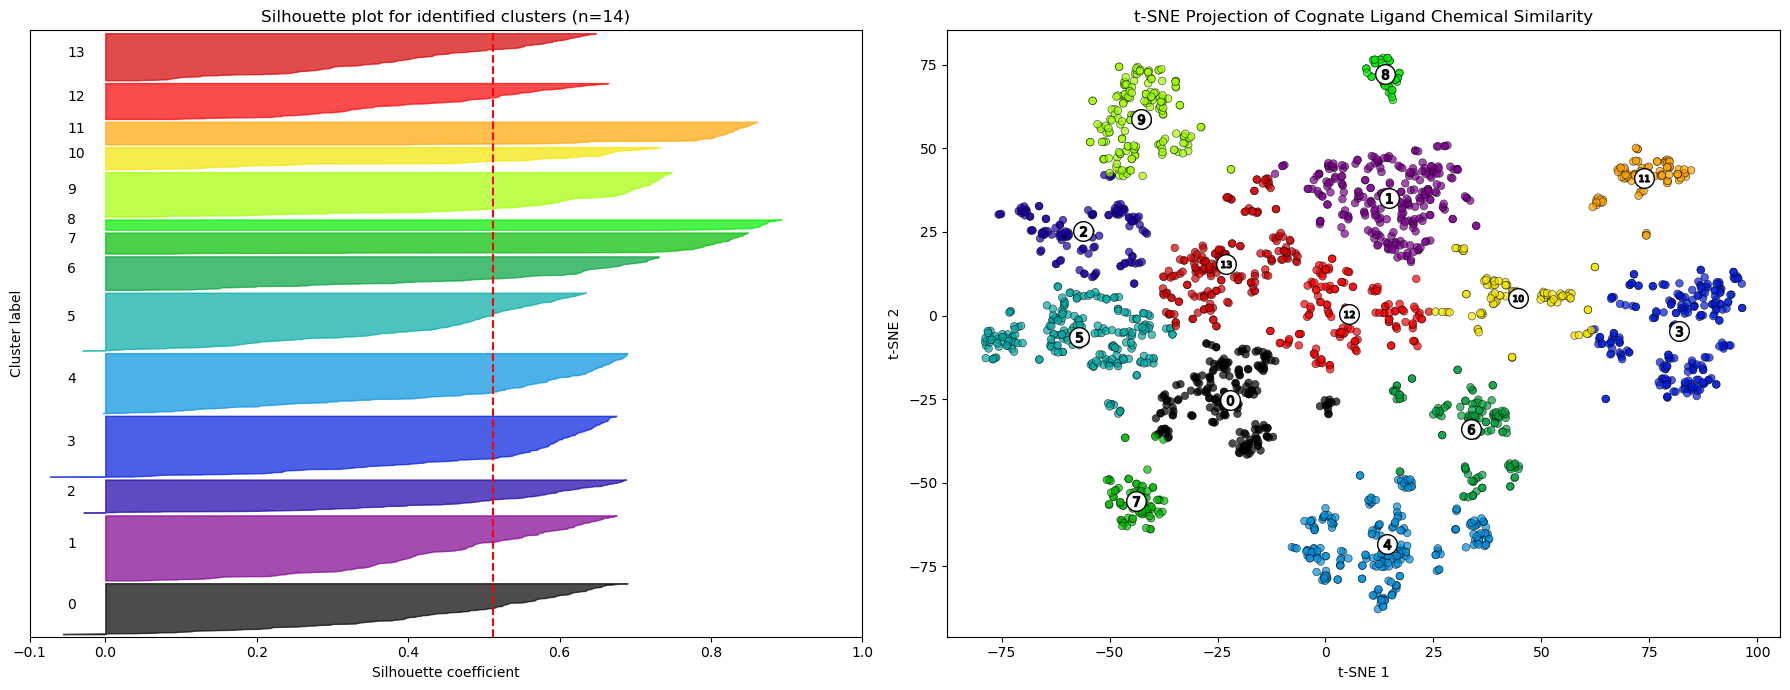

In [208]:
n_clusters = 14
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

#minimum seen is -0.066
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(X)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)
coglig_tsne["sample_silhouette_score"] = sample_silhouette_values
coglig_tsne["cluster_labels"] = cluster_labels
#interpret as categorical
coglig_tsne["cluster_labels"] = coglig_tsne["cluster_labels"].astype("str")

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("Silhouette plot for identified clusters (n=14)")
ax1.set_xlabel("Silhouette coefficient")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

sns.scatterplot(
    x=X[:, 0], y= X[:, 1],
    s=30, alpha=0.7, c=colors, edgecolor="k",
    axes = ax2
)

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

ax2.set_title("t-SNE Projection of Cognate Ligand Chemical Similarity")
ax2.set_xlabel("t-SNE 1")
ax2.set_ylabel("t-SNE 2")

plt.tight_layout()
fig.savefig(f"{analysis_output_path}/figures/cognate_ligand_clustering/cluster_silhouette_combined.svg")
plt.show()

In [209]:
sample_silhouette_values.min()

-0.07327167

For n_clusters = 14 The average silhouette_score is : 0.5114877


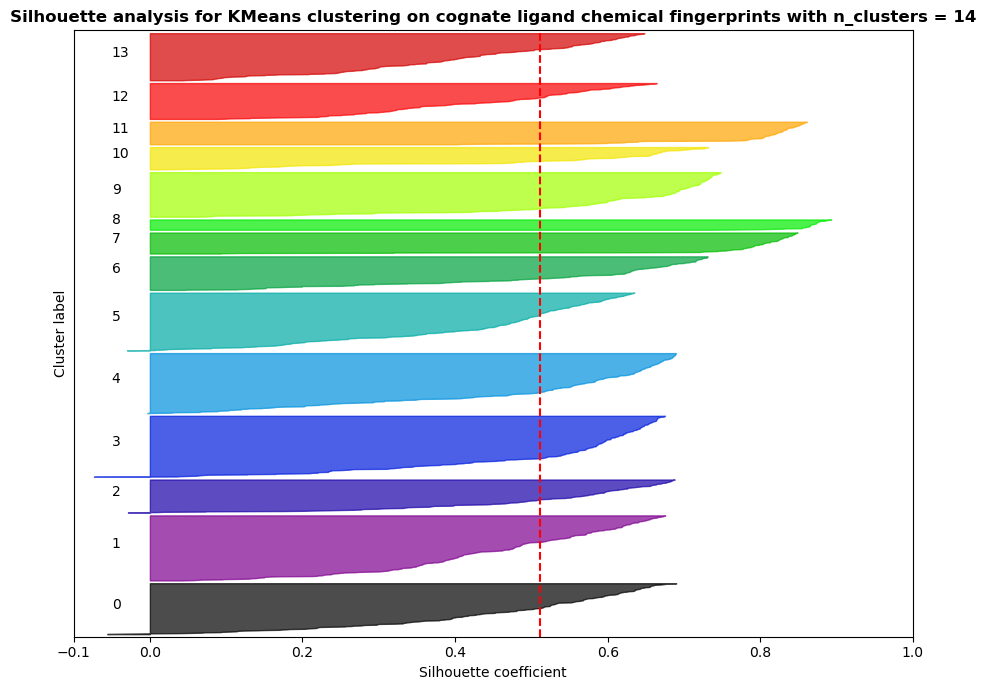

In [210]:
n_clusters = 14

# Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(X)

# The silhouette_score gives the average value for all the samples.
silhouette_avg = silhouette_score(X, cluster_labels)
print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

# Create the silhouette plot
fig, ax1 = plt.subplots()
fig.set_size_inches(9, 7)

# Minimum seen is -0.066
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("Silhouette analysis for KMeans clustering on cognate ligand chemical fingerprints with n_clusters = %d" % n_clusters, fontweight="bold")
ax1.set_xlabel("Silhouette coefficient")
ax1.set_ylabel("Cluster label")
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#plt.suptitle("Silhouette analysis for KMeans clustering on cognate ligand chemical fingerprints with n_clusters = %d" % n_clusters, fontsize=14, fontweight="bold")
#plt.show()
plt.tight_layout()
fig.savefig(f"{analysis_output_path}/figures/cognate_ligand_clustering/silhouette_analysis.svg")

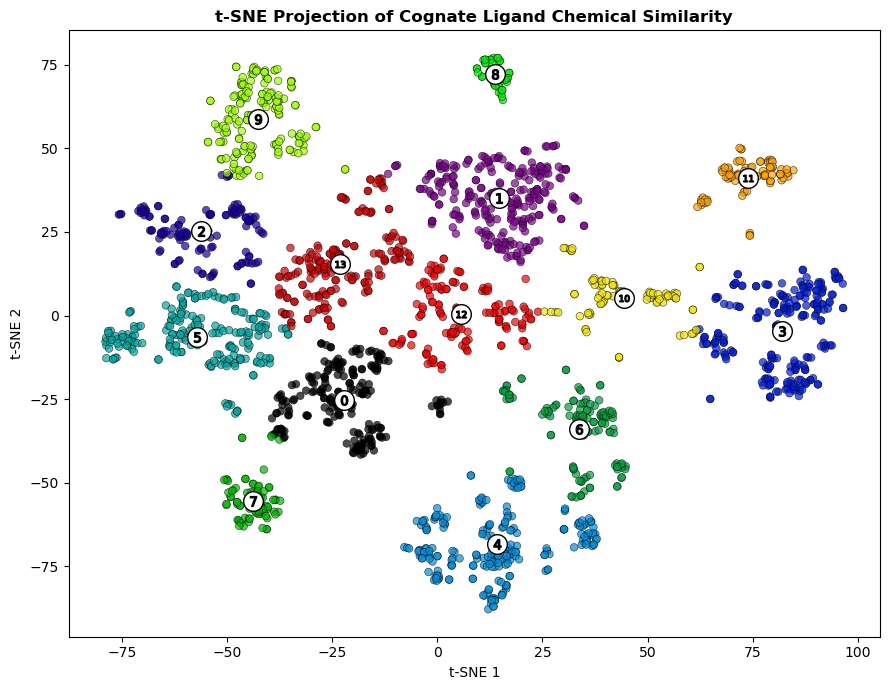

In [211]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

sns.scatterplot(
    x=X[:, 0], y= X[:, 1],
    s=30, alpha=0.7, c=colors, edgecolor="k"
)

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

plt.title("t-SNE Projection of Cognate Ligand Chemical Similarity", fontweight="bold")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

#plt.show()
plt.tight_layout()
fig.savefig(f"{analysis_output_path}/figures/cognate_ligand_clustering/tsne_clusters.svg")

In [212]:
superfamily_cogligs_query_result_exploded = superfamily_cogligs_query_result_exploded.merge(coglig_tsne[["coglig_name", "cluster_labels"]], on = "coglig_name", how = "left")

In [213]:
coglig_tsne.groupby("cluster_labels").agg({"sample_silhouette_score": "mean"}).sort_values(by = "sample_silhouette_score" , ascending = False)

,sample_silhouette_score
cluster_labels,
8,0.859833
11,0.785070
7,0.765891
9,0.605181
6,0.532250
3,0.514181
2,0.507875
4,0.499587
10,0.497672


### 4.3.3 Chemical Diversity in Domain Ligand Interactions

In [216]:
print(f"""
% superfamilies binding to 3 or fewer ligands: {len(superfamily_cogligs_query_mean_std_low) / len(superfamily_cogligs_query_mean_std)}
total num superfamilies compared: {len(superfamily_cogligs_query_mean_std)}
number superfamilies binding 3 or fewer ligands: {len(superfamily_cogligs_query_mean_std_low)}
number superfamilies binding 4+ ligands: {len(superfamily_cogligs_query_mean_std_multi)}""")

print(f"""
% multi ligand domains binding 4 cogligs only : {len(superfamily_cogligs_query_mean_std_multi.loc[superfamily_cogligs_query_mean_std_multi.num_cogligs == 4])/len(superfamily_cogligs_query_mean_std_multi)}
total multiligand domains : {len(superfamily_cogligs_query_mean_std_multi)}
""")

print(f"""
number 4+ coglig domains chemically similar: {len(superfamily_cogligs_query_mean_std_multi.loc[superfamily_cogligs_query_mean_std_multi.sim_mean >= 0.575])}
% 4+ coglig domains chemically similar: {len(superfamily_cogligs_query_mean_std_multi.loc[superfamily_cogligs_query_mean_std_multi.sim_mean >= 0.575])/len(superfamily_cogligs_query_mean_std_multi)}
""")

#maybe add here the number of 2/3 which are chemically similar? 
#can use that to say this is why we choose to use 4+ for promiscuous


% superfamilies binding to 3 or fewer ligands: 0.6238757154538022
total num superfamilies compared: 1223
number superfamilies binding 3 or fewer ligands: 763
number superfamilies binding 4+ ligands: 460

% multi ligand domains binding 4 cogligs only : 0.16956521739130434
total multiligand domains : 460


number 4+ coglig domains chemically similar: 72
% 4+ coglig domains chemically similar: 0.1565217391304348



In [366]:
## a cutoff determined by the rdkit authors for background similarity noise is 0.575 for randomly paired molecules so we set our similairty threhsold above that
top10_chemically_similar_domains = superfamily_cogligs_query_mean_std_multi.loc[superfamily_cogligs_query_mean_std_multi.sim_mean >= 0.6].sort_values("sim_mean", ascending = False).head(10)
top10_chemically_similar_domains["similar/dissimilar"] = "similar"
top10_chemically_similar_domains.to_csv(f"{analysis_output_path}/tables/top10_chemically_similar_domains.csv")

top10_chemically_distinct_domains = superfamily_cogligs_query_mean_std_multi.sort_values("sim_mean", ascending = True).head(10)
top10_chemically_distinct_domains["similar/dissimilar"] = "dissimilar"
top10_chemically_distinct_domains.to_csv(f"{analysis_output_path}/tables/top10_chemically_distinct_domains.csv")

top_sim_diff_domains = pd.concat([top10_chemically_similar_domains,top10_chemically_distinct_domains])


mostcogligs_chemically_similar_domains = superfamily_cogligs_query_mean_std_multi.loc[superfamily_cogligs_query_mean_std_multi.sim_mean >= 0.6].sort_values("num_cogligs", ascending = False).head(10)
mostcogligs_chemically_similar_domains.to_csv(f"{analysis_output_path}/tables/mostcogligs_chemically_similar_domains.csv", index = False)

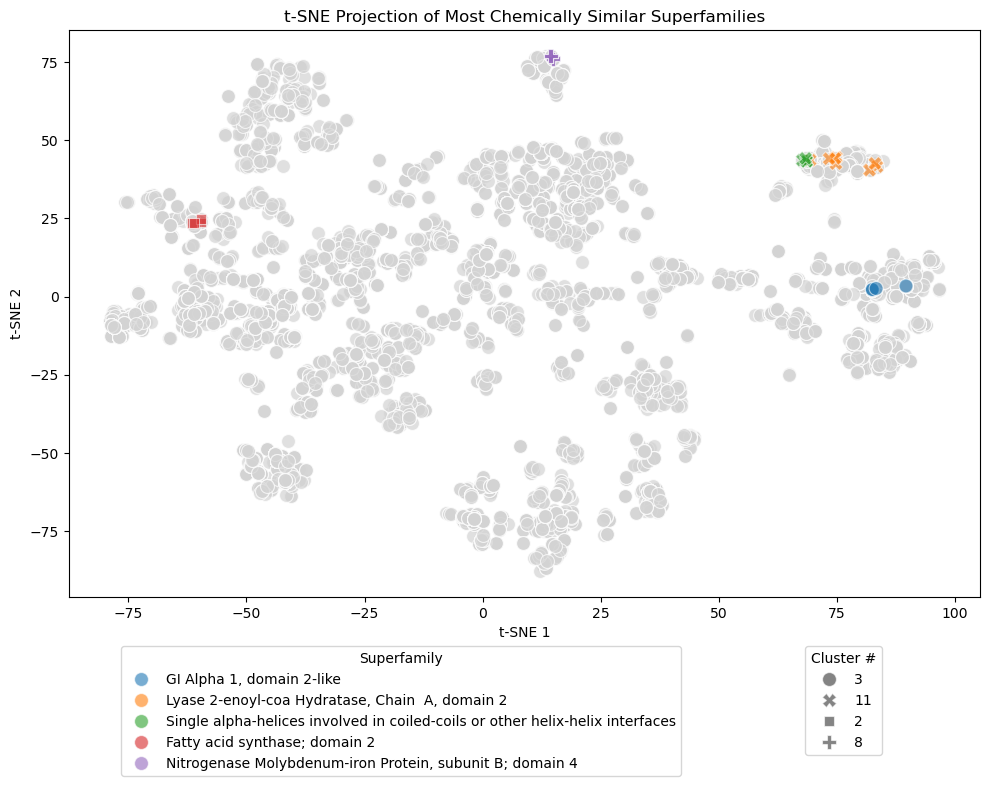

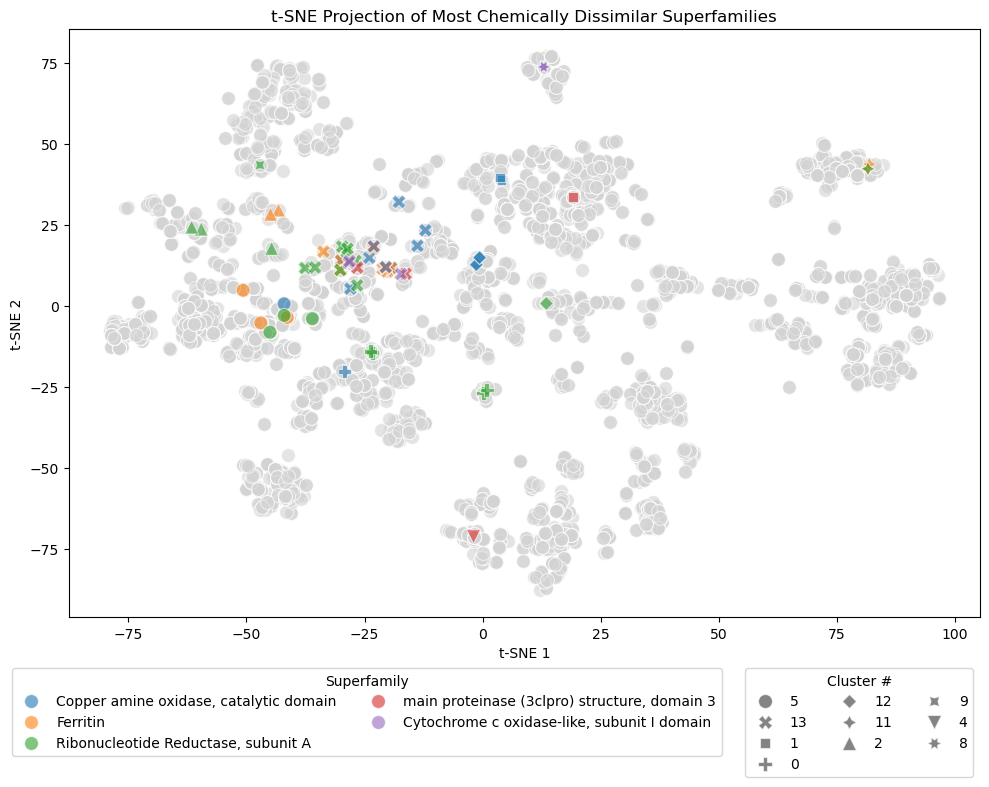

In [244]:
sim = superfamily_cogligs_query_result_exploded.loc[superfamily_cogligs_query_result_exploded.chs.isin(top10_chemically_similar_domains.head(5).chs.values.tolist())]

# Plotting t-SNE Results with Colors
fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(
    x='t-SNE 1', y='t-SNE 2', 
    data=superfamily_cogligs_query_result_exploded,
    s=100, alpha=0.7,
    color = "lightgrey",
)

scatter = sns.scatterplot(
    x='t-SNE 1', y='t-SNE 2', 
    data=sim.rename(columns = {"chs_desc": "Superfamily", "cluster_labels": "Cluster #"}),
    alpha = 0.6,
    hue = "Superfamily",
    style = "Cluster #",
    s=100
)
ax.set_title('t-SNE Projection of Most Chemically Similar Superfamilies')
#ax.set_title("A", fontfamily='sans', loc='left', fontsize='large')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.075), ncol=2)

# plt.tight_layout()
# fig.savefig("most_similar_superfamilies.svg")
# plt.show()

# Extract legend handles and labels
handles, labels = scatter.get_legend_handles_labels()

# Separate handles and labels for superfamilies and clusters
n_superfamilies = len(sim["chs_desc"].unique())
superfamily_handles = handles[1:n_superfamilies + 1]
superfamily_labels = labels[1:n_superfamilies + 1]
cluster_handles = handles[n_superfamilies + 2:]
cluster_labels = labels[n_superfamilies + 2:]

# Create the legends

legend2 = ax.legend(cluster_handles, cluster_labels, title="Cluster #", loc='upper right', bbox_to_anchor=(0.9, -0.075))

ax.add_artist(legend2)

legend1 = ax.legend(superfamily_handles, superfamily_labels, title="Superfamily", loc='upper left', bbox_to_anchor=(0.05, -0.075))

# Save and show plot
plt.tight_layout()
fig.savefig(f"{analysis_output_path}/figures/chemical_similarity_superfams/most_similar_superfamilies.svg")
plt.show()


diff = superfamily_cogligs_query_result_exploded.loc[superfamily_cogligs_query_result_exploded.chs.isin(top10_chemically_distinct_domains.head(5).chs.values.tolist())]

# Plotting t-SNE Results with Colors
fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(
    x='t-SNE 1', y='t-SNE 2', 
    data=superfamily_cogligs_query_result_exploded,
    alpha = 0.6,
    color = 'lightgrey',
    s=100
)

scatter = sns.scatterplot(
    x='t-SNE 1', y='t-SNE 2', 
    data=diff.rename(columns = {"chs_desc": "Superfamily", "cluster_labels": "Cluster #"}),
    alpha = 0.6,
    hue = "Superfamily",
    style = "Cluster #",
    s=100
)

ax.set_title('t-SNE Projection of Most Chemically Dissimilar Superfamilies')
#ax.set_title("B", fontfamily='sans', loc='left', fontsize='large')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
#ax.legend(title='Superfamily', loc='upper center', bbox_to_anchor=(0.5, -0.075), ncol=4)


# Extract legend handles and labels
handles, labels = scatter.get_legend_handles_labels()

# Separate handles and labels for superfamilies and clusters
n_superfamilies = len(diff["chs_desc"].unique())
superfamily_handles = handles[1:n_superfamilies + 1]
superfamily_labels = labels[1:n_superfamilies + 1]
cluster_handles = handles[n_superfamilies + 2:]
cluster_labels = labels[n_superfamilies + 2:]

# Create the legends
legend1 = ax.legend(superfamily_handles, superfamily_labels, title="Superfamily", loc='upper left', bbox_to_anchor=(-0.07, -0.075), ncols = 2)
ax.add_artist(legend1)

legend2 = ax.legend(cluster_handles, cluster_labels, title="Cluster #", loc='upper right', bbox_to_anchor=(1.00, -0.075), ncols = 3)

plt.tight_layout()
fig.savefig(f"{analysis_output_path}/figures/chemical_similarity_superfams/least_similar_superfamilies.svg")
plt.show()

In [245]:
top10_chemically_distinct_domains_ec_merged = top10_chemically_distinct_domains.merge(superfamily_cogligs_query_result[["chs", "ecList"]], on = "chs")
top10_chemically_similar_domains_ec_merged = top10_chemically_similar_domains.merge(superfamily_cogligs_query_result[["chs", "ecList"]], on = "chs")
top_sim_diff_domains_ec_merged = top_sim_diff_domains.merge(superfamily_cogligs_query_result[["chs", "ecList"]], on = "chs")

In [246]:
top10_chemically_distinct_domains_ec_merged["ecList_set"] = top10_chemically_distinct_domains_ec_merged.ecList.apply(lambda x: set([item for sublist in x for item in sublist]))
top10_chemically_similar_domains_ec_merged["ecList_set"] = top10_chemically_similar_domains_ec_merged.ecList.apply(lambda x: set([item for sublist in x for item in sublist]))
top_sim_diff_domains_ec_merged["ecList_set"] = top_sim_diff_domains_ec_merged.ecList.apply(lambda x: set([item for sublist in x for item in sublist]))

In [247]:
top10_chemically_distinct_domains_ec_merged["unique_ecs"] = top10_chemically_distinct_domains_ec_merged["ecList_set"].str.len()
top10_chemically_similar_domains_ec_merged["unique_ecs"] = top10_chemically_similar_domains_ec_merged["ecList_set"].str.len()
top_sim_diff_domains_ec_merged["unique_ecs"] = top_sim_diff_domains_ec_merged["ecList_set"].str.len()

top_sim_diff_domains_ec_merged.drop(columns = ["ecList", "ecList_set"], inplace = True)
top_sim_diff_domains_ec_merged.to_csv(f"{analysis_output_path}/tables/top_sim_diff_domains.csv", index = False)

In [248]:
top_sim_diff_domains_ec_merged.loc[top_sim_diff_domains_ec_merged["similar/dissimilar"] == "similar"].unique_ecs.mean()

3.8

In [249]:
top_sim_diff_domains_ec_merged.loc[top_sim_diff_domains_ec_merged["similar/dissimilar"] == "dissimilar"].unique_ecs.mean()

324.6

In [250]:
promiscuous_domains = superfamily_cogligs_query_mean_std_multi.loc[superfamily_cogligs_query_mean_std_multi.num_cogligs >= 4].sort_values(["num_cogligs", "sim_mean"], ascending = False)
promiscuous_domains_maccs = superfamily_cogligs_query_result_exploded.loc[superfamily_cogligs_query_result_exploded.chs.isin(promiscuous_domains.chs.unique())]

print(f"""
A total of {promiscuous_domains_maccs.chs.nunique()} CATH homologous superfamilies are identified as promiscuous. 
These superfamilies bind to a total of {promiscuous_domains_maccs.coglig_name.nunique()} different cognate ligands""")

top20_promiscuous_domains = promiscuous_domains.head(20)
top20_promiscuous_domains.to_csv(f"{analysis_output_path}/tables/top20_promiscuous_domains_with_sim.csv")

specific_superfamily_cogligs_query = """
MATCH (cl:cognateLigand)<-[sim:HAS_SIMILARITY {bestCognate: "Y"}]-(be:boundEntity)<-[int:INTERACTS_WITH_LIGAND]-(d:cathDomain)-[:IS_IN_CATH_HOMOLOGOUS_SUPERFAMILY]->(ch:cathHomologousSuperfamily {cathHomologousSuperfamily: $superfamily})
WHERE sim.parityScore >= 0.4 AND int.interactionMode <> "minor"
RETURN DISTINCT cl.name[0] as cl_name
"""
cath_3_20_20_80_cogligs = pd.DataFrame(conn.query(query = specific_superfamily_cogligs_query, db='neo4j', superfamily = "3.20.20.80"), columns = ["cl_name"])
cath_3_90_550_10_cogligs = pd.DataFrame(conn.query(query = specific_superfamily_cogligs_query, db='neo4j', superfamily = "3.90.550.10"), columns = ["cl_name"])
cath_3_90_79_10_cogligs = pd.DataFrame(conn.query(query = specific_superfamily_cogligs_query, db='neo4j', superfamily = "3.90.79.10"), columns = ["cl_name"])

top20_promiscuous_domains


A total of 460 CATH homologous superfamilies are identified as promiscuous. 
These superfamilies bind to a total of 2139 different cognate ligands


,chs,chs_desc,num_cogligs,sim_mean,sim_std
367,3.40.50.720,NAD(P)-binding Rossmann-like Domain,332.0,0.285303,0.184389
329,3.20.20.70,Aldolase class I,179.0,0.312888,0.205398
335,3.20.20.100,NADP-dependent oxidoreductase domain,162.0,0.305130,0.191503
416,3.40.50.1820,alpha/beta hydrolase,142.0,0.237281,0.157381
390,1.10.630.10,Cytochrome P450,135.0,0.265832,0.194844
397,3.50.50.60,FAD/NAD(P)-binding domain,129.0,0.260116,0.181585
309,3.40.50.300,P-loop containing nucleotide triphosphate hydr...,110.0,0.328517,0.249155
379,3.40.50.150,Vaccinia Virus protein VP39,103.0,0.274204,0.184562
289,3.40.640.10,Type I PLP-dependent aspartate aminotransferas...,99.0,0.340667,0.171880
123,3.20.20.80,Glycosidases,86.0,0.484512,0.233627


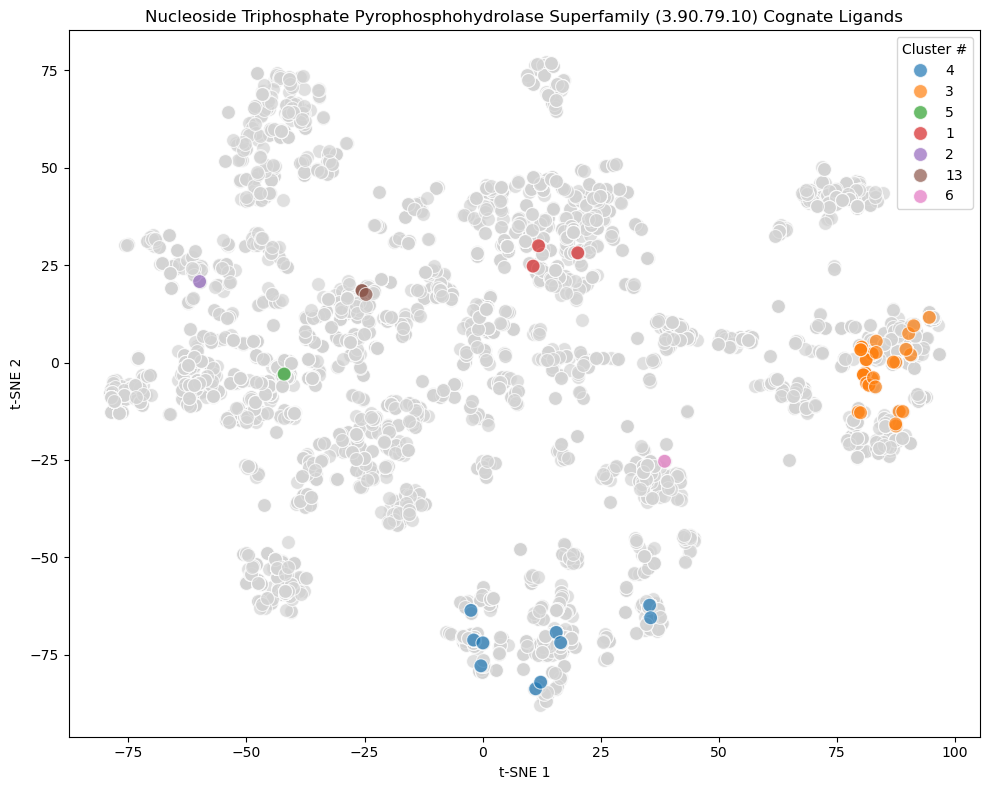

In [251]:
chs_3_90_79_10_cogligs = superfamily_cogligs_query_result_exploded.loc[superfamily_cogligs_query_result_exploded.chs.str.startswith("3.90.79.10")].copy()

# Plotting PCA Results with Colors
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x='t-SNE 1', y='t-SNE 2', 
    data=superfamily_cogligs_query_result_exploded,
    color = "lightgrey",
    alpha = 0.7,
    s=100
)

sns.scatterplot(
    x='t-SNE 1', y='t-SNE 2', 
    data=chs_3_90_79_10_cogligs,
    hue = "cluster_labels",
    alpha = 0.7,
    s=100
)

plt.legend(title='Cluster #', loc='upper right', ncol=1)
plt.title("Nucleoside Triphosphate Pyrophosphohydrolase Superfamily (3.90.79.10) Cognate Ligands")
plt.tight_layout()
plt.savefig(f"{analysis_output_path}/figures/superfamily_cognate_ligands/3_90_79_10_ligands.svg")

CATH 2.40.110.10 interacts with 23 potential cognate ligands


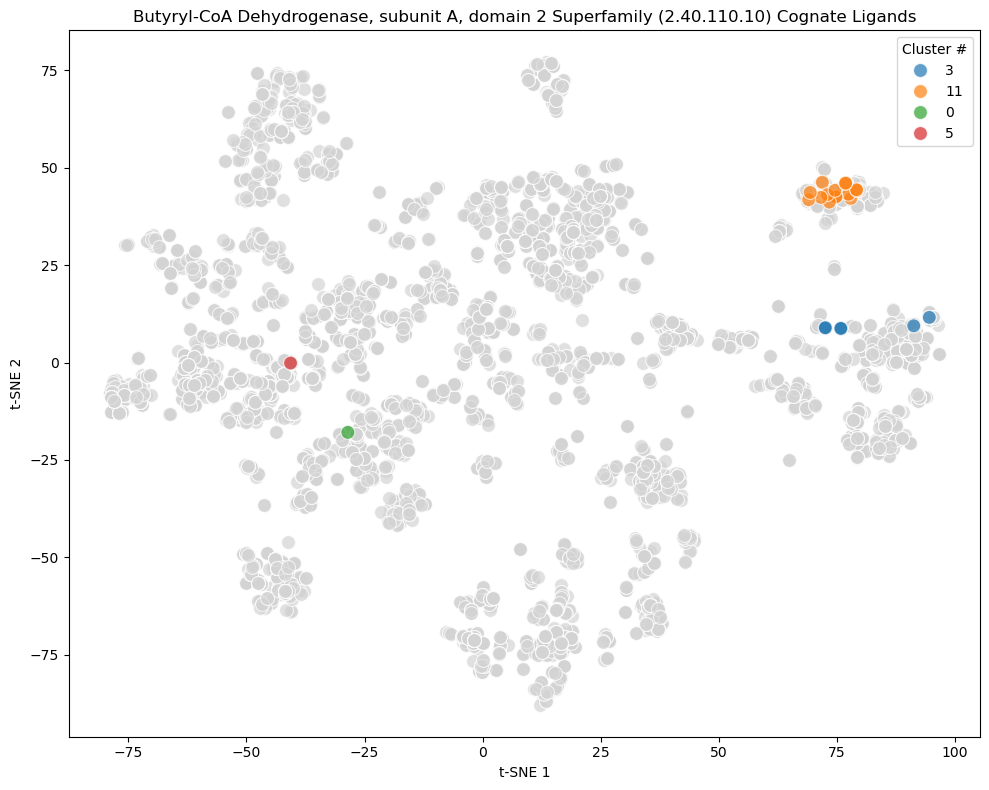

In [254]:
chs_2_40_110_10_cogligs = superfamily_cogligs_query_result_exploded.loc[superfamily_cogligs_query_result_exploded.chs.str.startswith("2.40.110.10")].copy()
print(f"CATH 2.40.110.10 interacts with {chs_2_40_110_10_cogligs.coglig_smiles.nunique()} potential cognate ligands")
# Plotting PCA Results with Colors
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x='t-SNE 1', y='t-SNE 2', 
    data=superfamily_cogligs_query_result_exploded,
    color = "lightgrey",
    alpha = 0.7,
    s=100
)

sns.scatterplot(
    x='t-SNE 1', y='t-SNE 2', 
    data=chs_2_40_110_10_cogligs,
    hue = "cluster_labels",
    alpha = 0.7,
    s=100
)

plt.legend(title='Cluster #', loc='upper right', ncol=1)
plt.title("Butyryl-CoA Dehydrogenase, subunit A, domain 2 Superfamily (2.40.110.10) Cognate Ligands")
plt.tight_layout()
plt.savefig(f"{analysis_output_path}/figures/superfamily_cognate_ligands/2_40_110_10_ligands.svg")

In [307]:
superfamily_cogligs_query_mean_std_multi.loc[superfamily_cogligs_query_mean_std_multi.chs == "3.40.50.1820"]

,chs,chs_desc,num_cogligs,sim_mean,sim_std
416,3.40.50.1820,alpha/beta hydrolase,142.0,0.237281,0.157381


In [256]:
rossman_folds = superfamily_cogligs_query_result_exploded.loc[superfamily_cogligs_query_result_exploded.chs.str.startswith("3.40.50")].copy()
rossman_folds["chs_stripped"] = rossman_folds["chs"].str.extract("(.*):")
top_chs_rossmann = superfamily_cogligs_query_mean_std.loc[(superfamily_cogligs_query_mean_std.chs.str.startswith("3.40.50")) & (superfamily_cogligs_query_mean_std.num_cogligs >= 4)].sort_values("sim_mean").head(5).chs.unique()
bottom_chs_rossmann = superfamily_cogligs_query_mean_std.loc[(superfamily_cogligs_query_mean_std.chs.str.startswith("3.40.50")) & (superfamily_cogligs_query_mean_std.num_cogligs >= 4)].sort_values("sim_mean").tail(5).chs.unique()

top_rossman_folds = rossman_folds.copy()
top_rossman_folds.loc[top_rossman_folds.chs.isin(top_chs_rossmann), "Color"] = top_rossman_folds.loc[top_rossman_folds.chs.isin(top_chs_rossmann)].chs
top_rossman_folds.loc[top_rossman_folds.Color.isna(), "Color"] = "Other"

bottom_rossman_folds = rossman_folds.copy()
bottom_rossman_folds.loc[bottom_rossman_folds.chs.isin(bottom_chs_rossmann), "Color"] = bottom_rossman_folds.loc[bottom_rossman_folds.chs.isin(bottom_chs_rossmann)].chs
bottom_rossman_folds.loc[bottom_rossman_folds.Color.isna(), "Color"] = "Other"

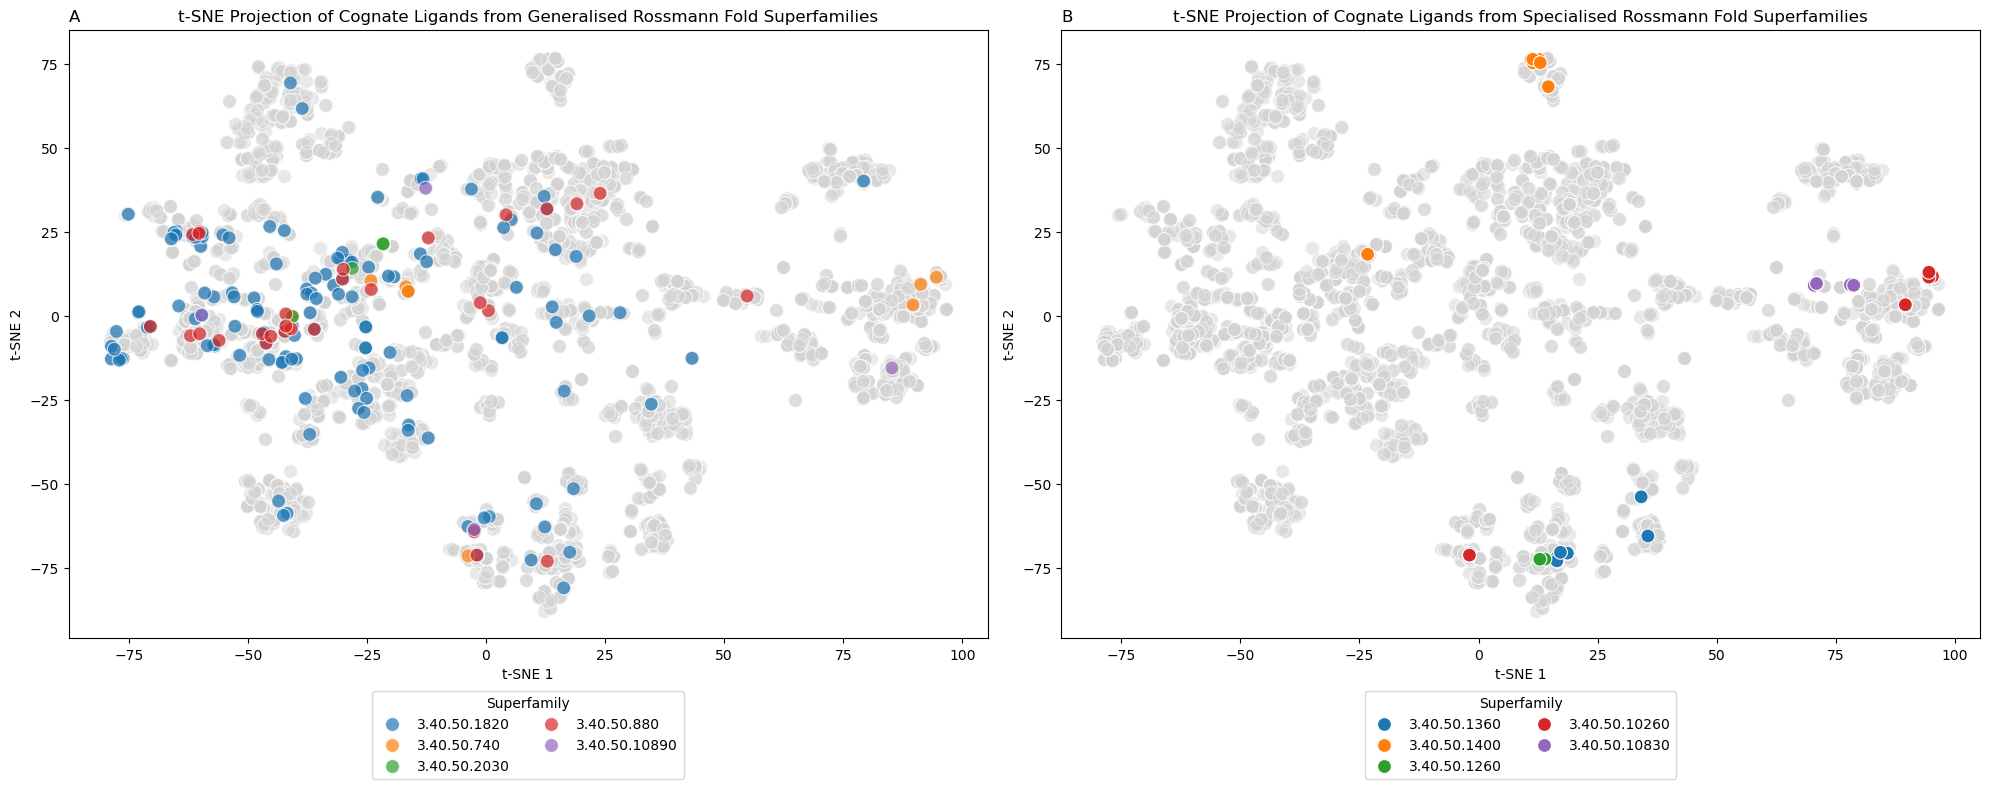

In [372]:
# Plotting PCA Results with Colors
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.scatterplot(
    x='t-SNE 1', y='t-SNE 2', 
    data=superfamily_cogligs_query_result_exploded,
    color='lightgray',
    alpha = 0.5,
    s=100,
    ax = axes[0]
)
sns.scatterplot(
    x='t-SNE 1', y='t-SNE 2', 
    data=top_rossman_folds.loc[~(top_rossman_folds.Color == "Other")],
    hue = "Color",
    alpha = 0.7,
    s=100,
    ax = axes[0]
)
axes[0].set_title('t-SNE Projection of Cognate Ligands from Generalised Rossmann Fold Superfamilies')
axes[0].set_title("A", fontfamily='sans', loc='left', fontsize='large')
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
axes[0].legend(title='Superfamily', loc='upper center', bbox_to_anchor=(0.5, -0.075), ncol=2)


sns.scatterplot(
    x='t-SNE 1', y='t-SNE 2', 
    data=superfamily_cogligs_query_result_exploded,
    color='lightgray',
    alpha = 0.5,
    s=100,
    ax = axes[1]
)

sns.scatterplot(
    x='t-SNE 1', y='t-SNE 2', 
    data=bottom_rossman_folds.loc[~(bottom_rossman_folds.Color == "Other")],
    hue = "Color",
    alpha = 1,
    s=100,
    ax = axes[1]
)


axes[1].set_title('t-SNE Projection of Cognate Ligands from Specialised Rossmann Fold Superfamilies')
axes[1].set_title("B", fontfamily='sans', loc='left', fontsize='large')
axes[1].set_xlabel(f't-SNE 1')
axes[1].set_ylabel(f't-SNE 2')
axes[1].legend(title='Superfamily', loc='upper center', bbox_to_anchor=(0.5, -0.075), ncol=2)

plt.tight_layout()
plt.savefig(f"{analysis_output_path}/figures/superfamily_cognate_ligands/most_least_similar_rossmann_superfamilies.svg")

## 4.3.5 Combinatorial Domain Interactions in ProCogGraph

In [264]:
#we need a second query for the number of times a given domain context is observed? 
#maybe we dont do such a large grouping and we do that in post processing in python.

def get_interaction_groups(interaction, interacting_superfamilies):
    coglig_dict = {}
    combined_unique_cogligs = set()
    for sf in interacting_superfamilies:
        dom_unique = domain_context_query_nogroup_result.loc[(domain_context_query_nogroup_result.domain_interaction.str.contains(f"{sf}:exclusive")) | (domain_context_query_nogroup_result.domain_interaction.str.contains(f"{sf}:dominant"))].coglig_name.unique()
        coglig_dict[f"{sf}_exclusive_dominant"] = dom_unique
        combined_unique_cogligs.update(dom_unique)
    interaction_cogligs = domain_context_query_nogroup_result.loc[(domain_context_query_nogroup_result.domain_interaction == interaction)].coglig_name.unique()
    coglig_dict[interaction] = interaction_cogligs
    unique_to_interaction = set(interaction_cogligs) - combined_unique_cogligs
    return coglig_dict, unique_to_interaction

domain_context_query_nogroup = """
MATCH (cl:cognateLigand)<-[sim:HAS_SIMILARITY]-(be:boundEntity)<-[int:INTERACTS_WITH_LIGAND]-(d:cathDomain)-[:IS_IN_CATH_HOMOLOGOUS_SUPERFAMILY]->(ch:cathHomologousSuperfamily) 
WHERE sim.parityScore >= 0.4 AND sim.bestCognate = "Y"  AND int.interactionMode <> "minor" 
WITH cl.uniqueID as clUID, cl.name[0] as clName, be.hetCode + ":" + be.uniqueID as beUID, be.ecList as ecs, COLLECT(ch.cathHomologousSuperfamily + ":" + int.interactionMode) AS domInt  
RETURN domInt, clUID, clName, beUID, ecs"""

domain_context_query_nogroup_result =  pd.DataFrame(conn.query(query = domain_context_query_nogroup, db='neo4j'), columns = ["domain_interaction", "cognate_ligand", "coglig_name", "bound_ligand", "ecs"])
domain_context_query_nogroup_result["domain_interaction"] = domain_context_query_nogroup_result["domain_interaction"].apply(lambda x: "-".join(sorted(x)))
domain_context_query_nogroup_result["pdb"] = domain_context_query_nogroup_result["bound_ligand"].str.extract(".*:([A-z0-9]{4})_")

#merge the coglig sne values with the domain contexts
domain_context_query_nogroup_result = domain_context_query_nogroup_result.merge(coglig_tsne, how = "left", on = "coglig_name")

In [300]:
print(f"""
Total number of unique domain combinations at homologous superfamily level: {domain_context_query_nogroup_result.domain_interaction.nunique()}
The total number of unique domain combinations (partner/major partner) = {domain_context_query_nogroup_result.loc[domain_context_query_nogroup_result.domain_interaction.str.contains("major_partner")  | domain_context_query_nogroup_result.domain_interaction.str.contains("partner")].domain_interaction.nunique()}
""")


Total number of unique domain combinations at homologous superfamily level: 2111
The total number of unique domain combinations (partner/major partner) = 1003



In [301]:
domain_context_counts = domain_context_query_nogroup_result.domain_interaction.value_counts().reset_index()
#in chapter use top 50 to illustrate the one domain one ligand hyptehsis holding steady.
domain_context_counts.head(50).to_csv(f"{analysis_output_path}/tables/domain_context_counts_top50.csv", index = False)

In [305]:
domain_context_counts_combo = domain_context_counts.loc[domain_context_counts.domain_interaction.str.contains("major_partner")  | domain_context_counts.domain_interaction.str.contains("partner")]
domain_context_counts_combo.to_csv(f"{analysis_output_path}/tables/domain_context_counts_combo.csv")

### Investigating the 3.40.50.720 (major partner) and 3.90.110.10 (partner) Interaction

This is the most common domain combination observed

In [309]:
_most_common, diff_ligs_int_most_common = get_interaction_groups("3.40.50.720:major_partner-3.90.110.10:partner", ["3.40.50.720", "3.90.110.10"])

In [316]:
diff_ligs_int_most_common

set()

We see that the cognate ligands bound here are not distinct from the individual cognate ligand interactiosn of the domains. Hence, the role here may be to bring the substrate and cofactor together as part of the reaction.

In [310]:
domain_context_query_nogroup_result.loc[domain_context_query_nogroup_result.domain_interaction == "3.40.50.720:major_partner-3.90.110.10:partner"].pdb.unique()

array(['3czm', '4qo8', '4qo7', '3vph', '4l4s', '4okn', '4mdh', '4nd4',
       '4jnk', '4nd3', '4nd2', '4nd1', '3pqd', '4i1i', '3h3j', '3h3f',
       '3om9', '4plz', '4ply', '4plw', '4plv', '4plt', '4plh', '4plg',
       '4plf', '4plc', '4m49', '1hyg', '3ldh', '3d4p', '2cmd', '3gvh',
       '1ur5', '1ez4', '2xxj', '2dfd', '2fn7', '2ldb', '2e37', '1lld',
       '2hjr', '1ie3', '2v7p', '1bmd', '2aa3', '1ib6', '1sow', '2a94',
       '2a92', '1ldn', '1ldm', '1ldg', '1smk', '1oc4', '1emd', '1hlp',
       '1wzi', '2x0r', '1wze', '1gv0', '1mld', '1guz', '1guy', '2x0j',
       '2x0i', '1bdm', '1uxk', '1uxj', '1uxi', '1uxh', '1uxg', '1t2f',
       '1t2e', '1t2d', '1pzh', '1t2c', '2cvq', '1pzg', '1pzf', '1t26',
       '1t25', '1y7t', '1t24', '1o6z', '1lth', '1i10', '1i0z', '1b8v',
       '1b8u', '1u5c', '1civ', '1hyh', '9ldt', '9ldb', '5ldh', '4r69',
       '4r68', '6h9s', '4uun', '6bb3', '6bb2', '6bb1', '5nqq', '6bb0',
       '6baz', '6bax', '5nqb', '6bal', '6bag', '6bad', '6cep', '5zi4',
      

We will investigate the structures of 4QO8, 4FDC and 4BV6.

#### Investigating the 3.10.180.10 domain combination

In [312]:
_, diff_ligs_int = get_interaction_groups("3.10.180.10:major_partner-3.10.180.10:partner", ["3.10.180.10", "3.10.180.10"])

In [313]:
_

{'3.10.180.10_exclusive_dominant': array(['HSO3-', '4-Hydroxymandelate', 'CO2', '3,4-dihydroxyphenylacetate',
        '5-formyl-2-hydroxyhepta-2,4-dienedioic acid', 'Oxygen',
        'Methylglyoxal', '2-Hydroxy-6-keto-2,4-heptadienoate',
        '4-Methylcatechol', 'Sulfate', 'Cysteine', '2-oxobutanoate',
        '2-Hydroxy-5-carboxymethylmuconate semialdehyde',
        'Biphenyl-2,3-diol', 'oxygen atom',
        '2-Hydroxymuconate semialdehyde',
        '3,4-dihydroxy-9,10-secoandrosta-1,3,5(10)-triene-9,17-dione',
        'Naphthalene-1,2-diol', '3-Chlorocatechol', '2-Bromoacetaldehyde',
        '3-(4-hydroxyphenyl)pyruvate', 'Cl-', 'Acetate'], dtype=object),
 '3.10.180.10:major_partner-3.10.180.10:partner': array(['2-oxobutanoate', 'O-phospho-L-homoserine', 'HPO4(2-)',
        'Methylglyoxal', '(R)-S-Lactoylglutathione',
        'Naphthalene-1,2-diol', 'Glutathione', '2-Oxoglutarate',
        'Glutamate'], dtype=object)}

In [990]:
diff_ligs_int

{'(R)-S-lactoylglutathione',
 '2-Oxoglutarate',
 'Glutamate',
 'Glutathione',
 'HPO4(2-)',
 'O-phospho-L-homoserine'}

In [991]:
_31018010_partner = domain_context_query_nogroup_result.loc[domain_context_query_nogroup_result.domain_interaction == "3.10.180.10:major_partner-3.10.180.10:partner"]#.pdb.unique()
_31018010_excl = domain_context_query_nogroup_result.loc[domain_context_query_nogroup_result.domain_interaction == "3.10.180.10:exclusive"]#.pdb.unique()

In [1083]:
test1 = _31018010_excl.ecs.explode()#.value_counts().head(20)
test1.loc[test1.str.startswith("2.5.1") == False].value_counts()

ecs
1.13.11.39    107
1.13.11.56     99
1.13.11.2      41
2.2.1.9        39
4.2.3.9        39
             ... 
1.13.11.88      3
1.13.11.12      3
1.13.11.17      3
1.13.11.49      3
1.13.11.67      3
Name: count, Length: 93, dtype: int64

In [1035]:
domain_context_query_nogroup_result.loc[domain_context_query_nogroup_result.pdb.isin(set(_31018010_partner.pdb.unique()).intersection(set(_31018010_excl.pdb.unique())))].pdb.unique() #.ecs.explode().value_counts()

array(['4naz', '4jh8', '4jh7', '4jh3', '2c21', '2ehz', '4ir0'],
      dtype=object)

In [318]:
#need to visualsie the structures of glutathione and napthalene-1,2-diol
glutathione_struct = superfamily_cogligs_query_result_exploded.loc[superfamily_cogligs_query_result_exploded.coglig_name == "Glutathione"].ROMol.values[0]
napthalene_struct = superfamily_cogligs_query_result_exploded.loc[superfamily_cogligs_query_result_exploded.coglig_name == "Naphthalene-1,2-diol"].ROMol.values[0]
Draw.MolToFile(glutathione_struct, f'{analysis_output_path}/figures/glutathione_napthalene_struct/glutathione_mol.svg', format='svg')
Draw.MolToFile(napthalene_struct, f'{analysis_output_path}/figures/glutathione_napthalene_struct/napthalene_mol.svg', format='svg')

#### Investigating 1.20.140.10:partner-1.20.140.10:partner-2.40.110.10:partner and major partner domain combination

In [ ]:
domain_context_query_nogroup_result.loc[(domain_context_query_nogroup_result.domain_interaction.str.contains("1.20.140.10:partner"))].groupby("domain_interaction").agg({"pdb": "nunique"})#.coglig_name.value_counts()

,pdb
domain_interaction,
1.10.1130.10:major_partner-1.10.1130.10:partner-1.20.140.10:partner,23
1.10.1130.10:major_partner-1.10.3820.10:partner-1.20.140.10:partner,2
1.10.1130.10:major_partner-1.20.140.10:partner,44
1.10.540.10:major_partner-1.20.140.10:partner,1
1.10.540.10:partner-1.20.140.10:partner-2.40.110.10:partner,2
1.20.140.10:major_partner-1.20.140.10:partner-1.20.140.10:partner,1
1.20.140.10:partner-1.20.140.10:partner-1.20.140.10:partner,2
1.20.140.10:partner-1.20.140.10:partner-2.40.110.10:major_partner,30
1.20.140.10:partner-1.20.140.10:partner-2.40.110.10:partner,44


In [1086]:
_3, diff_ligs_int_3 = get_interaction_groups("1.20.140.10:partner-1.20.140.10:partner-2.40.110.10:partner", ["1.20.140.10", "2.40.110.10"])

In [951]:
_4, diff_ligs_int_4 = get_interaction_groups("1.20.140.10:partner-2.40.110.10:partner", ["1.20.140.10", "2.40.110.10"])

In [1090]:
_4

{'1.20.140.10_exclusive_dominant': array(['CO2', 'Nitrite', 'aldehyde', 'Nitroethane',
        '4-hydroxyphenylacetate', 'Propanoyl-CoA', 'acryloyl-CoA',
        'Pyrrole-2-carbonyl-[pcp]', 'L-Prolyl-[pcp]'], dtype=object),
 '2.40.110.10_exclusive_dominant': array(['4-hydroxyphenylacetate', 'CO2'], dtype=object),
 '1.20.140.10:partner-2.40.110.10:partner': array(['FAD', 'FADH2'], dtype=object)}

In [1209]:
triple_agg = domain_context_query_nogroup_result.loc[(domain_context_query_nogroup_result.domain_interaction.str.contains("1.20.140.10:exclusive")) | 
                                        (domain_context_query_nogroup_result.domain_interaction.str.contains("1.20.140.10:dominant")) |
                                        (domain_context_query_nogroup_result.domain_interaction.str.contains("2.40.110.10:exclusive")) | 
                                        (domain_context_query_nogroup_result.domain_interaction.str.contains("2.40.110.10:dominant")) |
                                        (domain_context_query_nogroup_result.domain_interaction == "1.20.140.10:partner-1.20.140.10:partner-2.40.110.10:partner") |
                                        (domain_context_query_nogroup_result.domain_interaction == "1.20.140.10:partner-2.40.110.10:partner") |
                                        (domain_context_query_nogroup_result.domain_interaction == "1.20.140.10:partner-2.40.110.10:major_partner") |
                                        (domain_context_query_nogroup_result.domain_interaction == "1.20.140.10:partner-1.20.140.10:partner-2.40.110.10:major_partner")
                                       ].groupby(["domain_interaction", "coglig_name"]).agg({"t-SNE 1": "first", "t-SNE 2": "first", "pdb": "unique", "bound_ligand": "unique", "ecs": list}).reset_index()

In [1210]:
triple_agg.loc[(triple_agg.domain_interaction.str.contains("1.20.140.10:exclusive")) | (triple_agg.domain_interaction.str.contains("1.20.140.10:dominant")), "interaction"] = "1.20.140.10"
triple_agg.loc[(triple_agg.domain_interaction.str.contains("2.40.110.10:exclusive")) | (triple_agg.domain_interaction.str.contains("2.40.110.10:dominant")), "interaction"] = "2.40.110.10"
triple_agg["interaction"].fillna("combination", inplace = True)

/tmp/ipykernel_13896/2322915639.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





## EC Classes without representation in ProCogGraph

looking at the EC classes that do not ever have a coglig representation in procoggraph

In [367]:
total_ecids = pd.DataFrame(conn.query(query = "MATCH (ec:ecID) RETURN COUNT(DISTINCT(ec.ecID)) as ecids", db='neo4j'), columns = ["ecids"])

ecs_with_mapping_query = """
MATCH (ecs:ecSubClass)<-[:IS_IN_SUBCLASS]-(ecss:ecSubSubClass)-[:IS_IN_SUBSUBCLASS]-(ec:ecID) 
WHERE (ec)<-[:IS_IN_EC]-(:cognateLigand)<-[:HAS_SIMILARITY]-(:boundEntity) 
RETURN ecs.ecID as ecs_id, COUNT(DISTINCT(ec)) as num_ecs 
ORDER BY num_ecs DESC
"""
ecs_with_mapping_query_result = pd.DataFrame(conn.query(query = ecs_with_mapping_query, db='neo4j'), columns = ["ecs_id", "num_ecs"])

print(f"""{total_ecids.ecids.values[0]} total EC ids present in ProCogGraph""")
print(f"""{ecs_with_mapping_query_result.num_ecs.sum()} EC ids have a coglig mapping""")


ecs_without_mapping_query = """
MATCH (ecs:ecSubClass)<-[:IS_IN_SUBCLASS]-(ecss:ecSubSubClass)-[:IS_IN_SUBSUBCLASS]-(ec:ecID) 
WHERE NOT (ec)<-[:IS_IN_EC]-(:cognateLigand)<-[:HAS_SIMILARITY]-(:boundEntity) 
RETURN ecs.ecID as ecs_id, COUNT(DISTINCT(ec)) as num_ecs 
ORDER BY num_ecs DESC
"""
ecs_without_mapping_query_result = pd.DataFrame(conn.query(query = ecs_without_mapping_query, db='neo4j'), columns = ["ecs_id", "num_ecs"])
ecs_without_mapping_query_result.head(10).to_csv(f"{analysis_output_path}/tables/top10_ecs_without_coglig_mapping.csv", index = False)


print(f"""Total number of ECs without mapping : {ecs_without_mapping_query_result.num_ecs.sum()} - {ecs_without_mapping_query_result.num_ecs.sum()/total_ecids.ecids.values[0] * 100} % of total""")


print(f'''EC ids without mapping from 3.4/3.2/3.1 subclass: {ecs_without_mapping_query_result.loc[ecs_without_mapping_query_result.ecs_id.str.startswith("3.4") | 
                                    ecs_without_mapping_query_result.ecs_id.str.startswith("3.2") |
                                    ecs_without_mapping_query_result.ecs_id.str.startswith("3.1")].num_ecs.sum()}''')

print(f'''ECs 3.4/3.2/3.1 ids make up {ecs_without_mapping_query_result.loc[ecs_without_mapping_query_result.ecs_id.str.startswith("3.4") | 
                                    ecs_without_mapping_query_result.ecs_id.str.startswith("3.2") |
                                    ecs_without_mapping_query_result.ecs_id.str.startswith("3.1")].num_ecs.sum() / ecs_without_mapping_query_result.num_ecs.sum() * 100}% of these''')


ecs_without_mapping_query_result.head(10)

6753 total EC ids present in ProCogGraph
6197 EC ids have a coglig mapping
Total number of ECs without mapping : 556 - 8.233377758033466 % of total
EC ids without mapping from 3.4/3.2/3.1 subclass: 483
ECs 3.4/3.2/3.1 ids make up 86.87050359712231% of these


,ecs_id,num_ecs
0,3.4.-.-,341
1,3.2.-.-,88
2,3.1.-.-,54
3,2.4.-.-,17
4,4.2.-.-,16
5,2.3.-.-,12
6,5.4.-.-,4
7,5.1.-.-,3
8,3.5.-.-,2
9,4.6.-.-,2


## 4.3.7 Structurally informed subclass EC annotation compilation via cognate ligand detection

In [325]:
##INvestigating the partial EC annotations in ProCogGraph
partial_ec_protein_chains_query = """MATCH (a:entry)<-[:IS_IN_PDB]-(pc:proteinChain {partialEC : "True"}) RETURN COUNT(DISTINCT(a)) as num_pdbs, COUNT(DISTINCT(pc)) as num_protein_chains, "total_partial_protein_chains" as type
UNION 
MATCH (cl:cognateLigand)<-[sim:HAS_SIMILARITY]-(be:boundEntity)<-[:INTERACTS_WITH_LIGAND]-(d:cathDomain)-[:IS_IN_PROTEIN_CHAIN]->(pc:proteinChain {partialEC : "True"})-[:IS_IN_PDB]->(a:entry)
WHERE sim.parityScore >= 0.4 AND sim.bestCognate = "Y"
RETURN COUNT(DISTINCT(a)) as num_pdbs, COUNT(DISTINCT(pc)) as num_protein_chains, "partial with coglig match" as type"""

partial_ec_protein_chains_query_result = pd.DataFrame(conn.query(query = partial_ec_protein_chains_query, db='neo4j'), columns = ["num_pdbs","num_chains", "type"])

In [326]:
partial_ec_protein_chains_query_result

,num_pdbs,num_chains,type
0,15587,24041,total_partial_protein_chains
1,5545,7923,partial with coglig match


In [327]:
partial_ec_with_exact_ec_match_query = """
MATCH (ec:ecID)-[:IS_IN_EC]-(cl:cognateLigand)<-[sim:HAS_SIMILARITY]-(be:boundEntity)<-[:INTERACTS_WITH_LIGAND]-(d:cathDomain)-[:IS_IN_PROTEIN_CHAIN]->(pc:proteinChain {partialEC : "True"})-[:IS_IN_PDB]->(a:entry)
WHERE sim.parityScore >= 0.4 AND sim.bestCognate = "Y" 
WITH cl.name[0] as cl_name, sim.parityScore as score, be.hetCode as beHetCode, pc, COLLECT(DISTINCT(ec.ecID)) as coglig_ecs
WITH COLLECT(DISTINCT(cl_name)) as combined_cl_names, COLLECT(score) as combined_parity, COLLECT(DISTINCT(beHetCode)) as combined_be_hetcodes, apoc.coll.flatten(COLLECT(coglig_ecs)) as combined_coglig_ecs, pc
WITH combined_cl_names, combined_parity, combined_be_hetcodes, [id in pc.ecList WHERE id in combined_coglig_ecs] as pc_matched_ecs, pc, combined_coglig_ecs WHERE SIZE(pc_matched_ecs) = 1
RETURN pc.pdbProteinChain, pc.originalEC, combined_cl_names, combined_parity, combined_be_hetcodes, pc_matched_ecs, combined_coglig_ecs
"""

partial_ec_with_exact_ec_match_query_result =  pd.DataFrame(conn.query(query = partial_ec_with_exact_ec_match_query, db='neo4j'), columns = ["pdbProteinchain","originalEC", "combined_cl_names", "combined_scores", "combined_be_hetcodes", "pc_matched_ecs", "combined_coglig_ecs"])
partial_ec_with_exact_ec_match_query_result["originalEC_split"] = partial_ec_with_exact_ec_match_query_result["originalEC"].str.split(",")
partial_ec_with_exact_ec_match_query_result_of_interest = partial_ec_with_exact_ec_match_query_result.loc[~partial_ec_with_exact_ec_match_query_result.apply(lambda x: any([y in x.originalEC_split for y in x.pc_matched_ecs]), axis = 1 )].copy()
partial_ec_with_exact_ec_match_query_result_of_interest["mean_combined_score"] = partial_ec_with_exact_ec_match_query_result_of_interest.combined_scores.apply(lambda x: sum(x)/len(x))

In [360]:
#we have 1916 unique Protein chains with the potential to assign a single unique EC id to. 
print(len(partial_ec_with_exact_ec_match_query_result))
#How many of these are being matched back to original ECs (and so we can disregard).
print(len(partial_ec_with_exact_ec_match_query_result.loc[partial_ec_with_exact_ec_match_query_result.apply(lambda x: any([y in x.originalEC_split for y in x.pc_matched_ecs]), axis = 1 )]))
#How many matches of interest?
print(len(partial_ec_with_exact_ec_match_query_result_of_interest))
#How many matches of interest are being made through exact cognate ligand matches?
print(len(partial_ec_with_exact_ec_match_query_result_of_interest.loc[partial_ec_with_exact_ec_match_query_result_of_interest.mean_combined_score == 1]))
#as a perc
print(f"{314/1312} assignments through perfect match")

1916
604
1312
314
0.23932926829268292 assignments through perfect match


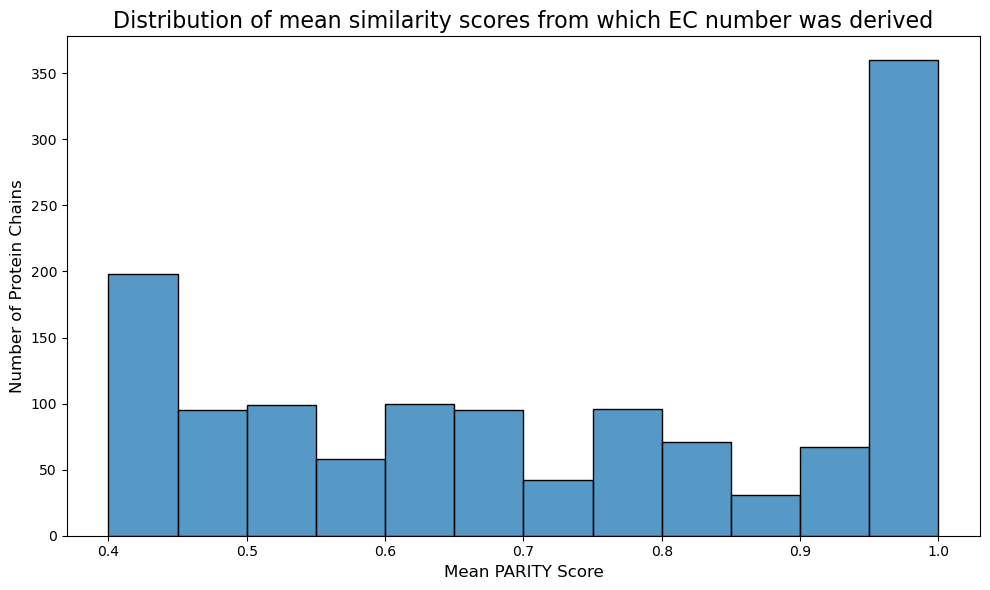

In [365]:
#distibution of scores from which ecs were derived
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(partial_ec_with_exact_ec_match_query_result_of_interest.mean_combined_score)

# format figure
plt.title('Distribution of mean similarity scores from which EC number was derived', fontsize=16)
plt.xlabel('Mean PARITY Score', fontsize=12)
plt.ylabel('Number of Protein Chains', fontsize=12)
plt.tight_layout()

plt.savefig(f"{analysis_output_path}/figures/ec_matching/score_distribution.svg")

In [382]:
#there are 1312 of these in which we have an interesting assingment. take a random sampel as a csv
partial_ec_assignment_sample = partial_ec_with_exact_ec_match_query_result_of_interest.sample(n = 40, random_state = 1)
partial_ec_assignment_sample.to_csv(f"{analysis_output_path}/tables/partial_ec_assignment_sample.csv")
partial_ec_with_exact_ec_match_query_result_of_interest.to_csv(f"{analysis_output_path}/tables/partial_ec_assignment_all.csv")

In [383]:
partial_ec_assignment_sample

,pdbProteinchain,originalEC,combined_cl_names,combined_scores,combined_be_hetcodes,pc_matched_ecs,combined_coglig_ecs,originalEC_split,mean_combined_score
305,1xkl_A,3.1.1.-,[Dihydrocoumarin],[0.6428571428571429],[STH],[3.1.1.35],[3.1.1.35],[3.1.1.-],0.642857
188,5f6x_A,2.3.2.-,[4-Hydroxymethylphenylhydrazine],[0.4],[5VM],[2.3.2.9],[2.3.2.9],[2.3.2.-],0.400000
387,3oei_C,3.1.-.-,"[1,2,3-propanetricarboxylate]",[0.9230769230769231],[FLC],[3.1.1.87],[3.1.1.87],[3.1.-.-],0.923077
1495,6g32_B,"2.5.1.1,2.5.1.10,2.5.1.29,2.5.1.-",[2-oxobutanoate],[0.625],[GOL],[2.5.1.48],"[4.4.1.2, 4.4.1.11, 4.4.1.1, 4.3.1.19, 4.1.1.1...","[2.5.1.1, 2.5.1.10, 2.5.1.29, 2.5.1.-]",0.625000
299,1b9i_A,"2.6.1.-,4.2.1.144",[Pyridoxamine phosphate],[0.64],[PXG],[2.6.1.54],"[3.1.3.74, 2.7.1.35, 2.6.1.54, 1.4.3.5]","[2.6.1.-, 4.2.1.144]",0.640000
1484,5g2p_C,2.6.1.-,[Pyridoxal phosphate],[1.0],[PLP],[2.6.1.54],"[4.3.3.6, 3.1.3.74, 2.7.1.35, 2.6.1.54, 1.4.3.5]",[2.6.1.-],1.000000
1638,2yrr_A,2.6.1.-,[Pyridoxal phosphate],[1.0],[PLP],[2.6.1.54],"[4.3.3.6, 3.1.3.74, 2.7.1.35, 2.6.1.54, 1.4.3.5]",[2.6.1.-],1.000000
431,4tnx_D,3.1.5.-,[dGTP],"[1.0, 0.96875]","[DGT, GTP]",[3.1.5.1],"[3.6.1.9, 3.1.5.1, 2.7.7.7, 2.7.4.6, 2.7.1.40,...",[3.1.5.-],0.984375
410,4tnp_D,3.1.5.-,[dGTP],"[0.5526315789473685, 0.96875]","[DCP, GTP]",[3.1.5.1],"[3.6.1.9, 3.1.5.1, 2.7.7.7, 2.7.4.6, 2.7.1.40,...",[3.1.5.-],0.760691
380,3a76_A,4.5.1.-,[Pyruvate],[0.7142857142857143],[GOL],[4.5.1.2],"[7.2.4.2, 6.4.1.1, 4.5.1.2, 4.4.1.36, 4.4.1.35...",[4.5.1.-],0.714286


In [ ]:
#we will use 2vno to demonstrate in figure

In [364]:
graph_query_for_figure = """
MATCH (a:entry {pdbEntry: "2vno"})<-[f:IS_IN_PDB]-(e:boundEntity)-[sim:HAS_SIMILARITY]->(cl:cognateLigand)-[g:IS_IN_EC]->(ec:ecID) WHERE sim.parityScore >= 0.4 AND sim.bestCognate = "Y" RETURN *"""

graph_query_for_figure_all = """
MATCH (a:entry {pdbEntry: "2vno"})<-[f:IS_IN_PDB]-(e:boundEntity)-[sim:HAS_SIMILARITY]->(cl:cognateLigand)-[g:IS_IN_EC]->(ec:ecID) WHERE sim.parityScore >= 0.4 RETURN *"""

## Section 4.3.7 Annotation of Metatranscriptomes

Data from tripartite soil paper is from https://microbiomejournal.biomedcentral.com/articles/10.1186/s40168-018-0432-5

Ocean metatranscriptome : https://onlinelibrary.wiley.com/doi/full/10.1002/edn3.353

In [330]:
#functions for preprocessing cognate ligand data

def get_be_domain_contexts(score_cutoff, domain_type, conn):
    be_domain_context_query = """MATCH (ec:ecID)<-[:IS_IN_EC]-(cl:cognateLigand)<-[sim:HAS_SIMILARITY]-(be:boundEntity)<-[int:INTERACTS_WITH_LIGAND]-(d:domain {type: $domain})-[:IS_IN_PROTEIN_CHAIN]->(pc:proteinChain)-[:IS_IN_PDB]->(a:entry) 
    WHERE sim.parityScore >= toFloat($score_cutoff) AND sim.bestCognate in ["Y"] AND int.interactionMode <> 'minor'
WITH cl.uniqueID as clUID, cl.name[0] as clName, cl.isCofactor as clCofactor, sim.parityScore as score, be.uniqueID as beUID, be.ligandUniqueID as bdUID, be.description as beName, a.pdbEntry as pdb, d.group + ':' + int.interactionMode AS domInt, pc.pdbProteinChain as proteinChain, pc.ecList as pcEcList, COLLECT(DISTINCT(ec.ecID)) as ecID
    WITH clUID, clName, clCofactor, score, beUID, bdUID, beName, pdb, apoc.coll.sort(COLLECT(domInt)) as domInt, COLLECT(DISTINCT(proteinChain)) as proteinChains, ecID, apoc.coll.flatten(COLLECT(pcEcList)) as pcEcList
    WHERE size(proteinChains) = 1 AND ANY(ec IN ecID WHERE ec IN pcEcList)
    RETURN clUID, clName, clCofactor, score, beUID, bdUID, beName, pdb, domInt, proteinChains, [ec in ecID WHERE ec in pcEcList] as ecID
    """

    #get the mean of all the matches to a cooglig for domint then filter based on that ?
    #limit promiscuous domains to top n matches (where more than n matches with same score, ties broken by random shuffle (using a seed for reproducibility)

    be_domain_contexts = pd.DataFrame(conn.query(query = be_domain_context_query, db='neo4j', domain = domain_type, score_cutoff = score_cutoff), columns = ["clUID", "clName", "clCofactor", "score", "beUID", "bdUID", "beName", "pdb", "domInt", "proteinChains", "ecID"])
    be_domain_contexts["domInt"] = be_domain_contexts["domInt"].str.join(",")
    be_domain_contexts["clCombo"] = be_domain_contexts["clUID"] + ":" + be_domain_contexts["clName"] + ":" + be_domain_contexts["clCofactor"]
    be_domain_contexts["bdCombo"] = be_domain_contexts["bdUID"] + ":" + be_domain_contexts["beName"]
    return be_domain_contexts

def agg_be_domain_contexts(be_domain_contexts, include_score_cutoff = 0.4, mean_score_cutoff = 0.4, max_ec_l2 = 2, max_ec_l3 = 5):
    #filter the bound entities to only those that meet the minimum score specified (default 0.4)
    be_domain_contexts_filtered = be_domain_contexts.loc[be_domain_contexts.score >= include_score_cutoff].copy()
    be_domain_contexts_filtered.drop(columns = ["proteinChains"], inplace = True)
    
    #group    
    be_domain_contexts_filtered_domint_grouped = be_domain_contexts_filtered[["clCombo", "domInt", "ecID", "score"]].groupby(["clCombo", "domInt"]).agg({"ecID": list, "score": "mean"}).rename(columns = {"score": "mean_be_score"}).reset_index()
    be_domain_contexts_filtered_domint_grouped["ecID"] = be_domain_contexts_filtered_domint_grouped["ecID"].apply(lambda x: set(y for sublist in x for y in sublist))
    
    #filter to remove domain interactions that occur across many ec's at subclass and subsubclass level according to user filters.
    be_domain_contexts_filtered_domint_grouped["ec_l2"] = be_domain_contexts_filtered_domint_grouped["ecID"].apply(lambda x: set([re.match("(\d+\.\d+)\.\d+\.", y)[1] for y in x]))
    be_domain_contexts_filtered_domint_grouped["ec_l3"] = be_domain_contexts_filtered_domint_grouped["ecID"].apply(lambda x: set([re.match("(\d+\.\d+\.\d+)\.", y)[1] for y in x]))
    
    if max_ec_l2 > 0:
        be_domain_contexts_filtered_ec_l2_filtered = be_domain_contexts_filtered_domint_grouped.loc[be_domain_contexts_filtered_domint_grouped.ec_l2.str.len() <= max_ec_l2].copy()
    else:
        be_domain_contexts_filtered_ec_l2_filtered = be_domain_contexts_filtered.copy()
    if max_ec_l3 > 0:
        be_domain_contexts_filtered_ec_l3_filtered = be_domain_contexts_filtered_ec_l2_filtered.loc[be_domain_contexts_filtered_ec_l2_filtered.ec_l3.str.len() <= max_ec_l3].copy()
    else:
        be_domain_contexts_filtered_ec_l3_filtered = be_domain_contexts_filtered_ec_l2_filtered.copy()
    
    be_domain_contexts_filtered_ec_l3_filtered.drop(columns = ["ec_l2", "ec_l3"], inplace = True)
    
    #find cognate ligands with mean score above specified cutoff
    be_domain_contexts_score = be_domain_contexts_filtered_ec_l3_filtered.loc[(be_domain_contexts_filtered_ec_l3_filtered.mean_be_score >= mean_score_cutoff)].copy()
    #format columns before returning
    be_domain_contexts_score["be_supporting_domint"] = be_domain_contexts_score["ecID"].str.len()
    be_domain_contexts_score["total_be_domint"] = be_domain_contexts_score.groupby("domInt")["be_supporting_domint"].transform("sum")
    be_domain_contexts_score["ecID"] = be_domain_contexts_score["ecID"].str.join(",")
    be_domain_contexts_score["be_supporting_ec"] = be_domain_contexts_score.groupby(["domInt", "ecID"])["be_supporting_domint"].transform("sum")    
    be_domain_contexts_score["domains"] = be_domain_contexts_score.domInt.str.findall('([^,:]+):[^,]+')
    be_domain_contexts_score["num_domInt_cogligs_total"] = be_domain_contexts_score.groupby("domInt")["clCombo"].transform("nunique")
    be_domain_contexts_score["clCombo"] = be_domain_contexts_score["clCombo"] + ":" + be_domain_contexts_score["mean_be_score"].round(3).astype("str")

    #make an ec level df for annotating just EC from coglig mappings.
    be_domain_contexts_score_ec = be_domain_contexts_score.copy()
    be_domain_contexts_score_ec["domains"] = be_domain_contexts_score_ec["domains"].str.join(",")
    be_domain_contexts_score_ec_unique = be_domain_contexts_score_ec[[col for col in be_domain_contexts_score_ec.columns if not col in ["clCombo", "mean_be_score", "be_supporting_domint"]]].drop_duplicates()
    be_domain_contexts_score_ec_unique = be_domain_contexts_score_ec_unique.groupby("domInt").agg({"ecID": list, "domains": "first"}).reset_index()
    be_domain_contexts_score_ec_unique["ec_set"] = be_domain_contexts_score_ec_unique.ecID.apply(lambda x: set(y for sublist in x for y in sublist.split(",")))
    be_domain_contexts_score_ec_unique["domains"] = be_domain_contexts_score_ec_unique.domains.str.split(",")
    
    
    return be_domain_contexts_score, be_domain_contexts_score_ec_unique

from collections import Counter
#function for checking sublists taken from https://stackoverflow.com/questions/68390939/how-to-check-if-a-list-contains-all-the-elements-of-another-list-including-dupli
def contains(l1, l2):
    return not (Counter(l2) - Counter(l1))

def get_cds_cogligs(accession, domain_list, cognate_ligand_mapping, num_ligs = 10):
    ##should also find a way to make the selections when there is combination interactions, to keep individual interactions that correspond with ec lists of potnetial combinations?
    ##first find exclusive matches where any domain in input list is the only domain in the mapping for a coglig
    domain_mappings = []
    
    cognate_ligand_mapping[["clUID", "clName", "cofactor", "mean_be_score"]] = cognate_ligand_mapping.clCombo.str.split(":", n = 3, expand = True)
    
    for domain in set(domain_list): #dont do duplicate domains twice in exclusive search
        if num_ligs > 0:
            domain_cogligs_exclusive = cognate_ligand_mapping.loc[cognate_ligand_mapping.domains.apply(lambda x: sorted(x) == sorted([domain]))].sort_values(["mean_be_score"], ascending = False).head(num_ligs)
        else:
            domain_cogligs_exclusive = cognate_ligand_mapping.loc[cognate_ligand_mapping.domains.apply(lambda x: sorted(x) == sorted([domain]))].sort_values(["mean_be_score"], ascending = False)
        domain_cogligs_exclusive.drop(columns = ["mean_be_score"], inplace = True)
        if not domain_cogligs_exclusive.empty:
            domain_mappings.append(domain_cogligs_exclusive)
    ##then find the matches where all domains in the mapping item are present in the domain list.
    if len(domain_list) > 1:
        domain_cogligs_partner = cognate_ligand_mapping.loc[(cognate_ligand_mapping.domains.apply(lambda x: contains(domain_list, x))) & (cognate_ligand_mapping.domains.str.len() > 1)]
        if num_ligs > 0:
            domain_cogligs_partner_filtered = domain_cogligs_partner.groupby("domInt", group_keys=True).apply(lambda x: x.sort_values(["mean_be_score"], ascending=False).head(num_ligs), include_groups = False).reset_index()
        else:
            domain_cogligs_partner_filtered = domain_cogligs_partner.groupby("domInt", group_keys=True).apply(lambda x: x.sort_values(["mean_be_score"], ascending=False), include_groups = False).reset_index()
        if "level_1" in domain_cogligs_partner_filtered.columns:
            domain_cogligs_partner_filtered.drop(columns = "level_1", inplace = True)
        domain_cogligs_partner_filtered.drop(columns = ["mean_be_score"], inplace = True)
        if not domain_cogligs_partner_filtered.empty:
            domain_mappings.append(domain_cogligs_partner_filtered)
    if len(domain_mappings) > 0:
        domain_mappings_df = pd.concat(domain_mappings)
        domain_mappings_df["accession"] = accession
        return domain_mappings_df
    else:
        return None

def get_cds_ec_profile(accession, domain_list, ec_mapping):
    domain_mappings = []
    for domain in set(domain_list): #dont do duplicate domains twice in exclusive search
        domain_ecs_exclusive = ec_mapping.loc[ec_mapping.domains.apply(lambda x: sorted(x) == sorted([domain]))]
        if not domain_ecs_exclusive.empty:
            domain_mappings.append(domain_ecs_exclusive)
    ##then find the matches where all domains in the mapping item are present in the domain list.
    if len(domain_list) > 1:
        domain_ecs_partner = ec_mapping.loc[(ec_mapping.domains.apply(lambda x: contains(domain_list, x))) & (ec_mapping.domains.str.len() > 1)]
        if not domain_ecs_partner.empty:
            domain_mappings.append(domain_ecs_partner)
    if len(domain_mappings) > 0:
        domain_mappings_df = pd.concat(domain_mappings)
        domain_mappings_df["accession"] = accession
        return domain_mappings_df
    else:
        return None
    

import re
from multiprocessing import Pool
#function to process a df in parallel
# Function to process a single row
def process_row_coglig(row, num_ligs = -1 , cognate_ligand_list = [], ec_list = []):
    cognate_ligand_mapping = pfam_domain_contexts_unique.copy()
    if len(cognate_ligand_list) > 0:
        cognate_ligand_mapping = cognate_ligand_mapping.loc[cognate_ligand_mapping.clUID in cognate_ligand_list].copy()
    if len(ec_list) > 0:
        cognate_ligand_mapping = cognate_ligand_mapping.loc[cognate_ligand_mapping.ecID.str.split(",").apply(lambda ec_ids: any(ec.startswith(ec_prefix) for ec in ec_ids for ec_prefix in ec_list))].copy()
    return get_cds_cogligs(row.accession, row.domain, cognate_ligand_mapping, num_ligs = num_ligs)


def process_row_ec(row, ec_list = []):
    ec_mapping = pfam_domain_contexts_unique_ec.copy()
    if len(ec_list) > 0:
        ec_mapping = ec_mapping.loc[ec_mapping.ec_set.apply(lambda ec_ids: any(ec.startswith(ec_prefix) for ec in ec_ids for ec_prefix in ec_list))].copy()
    return get_cds_ec_profile(row.accession, row.domain, ec_mapping)

def analyse_sample(sample_df, n_parallel = 1, num_ligs = -1, analysis_type = "coglig", cognate_ligand_list = [], ec_list = []):
    
    with Pool(n_parallel) as pool:
        if analysis_type == "coglig":
            tasks = [(row, -1 ,cognate_ligand_list, ec_list) for _, row in sample_df.iterrows()]
            results = pool.starmap(process_row_coglig, tasks)
        else:
            tasks = [(row, ec_list) for _, row in sample_df.iterrows()]
            results = pool.starmap(process_row_ec, tasks)
    sample_results_df = pd.concat(results)
    return sample_results_df


def find_ec_ranges(ec_list):
    #get fourht level ec
    ec_dict = {}
    for ec in ec_list:
        parts = ec.split('.')
        prefix = '.'.join(parts[:3])
        fourth_level = parts[3]
        if prefix not in ec_dict:
            ec_dict[prefix] = {'numeric': [], 'nonnumeric': []}
        
        #make a separate set for numeric and nonnumeric
        if fourth_level.isnumeric():
            ec_dict[prefix]['numeric'].append(int(fourth_level))
        else:
            ec_dict[prefix]['nonnumeric'].append(fourth_level)

    #aggregate the ranges of the different ecs
    ec_ranges = []
    for prefix, levels in ec_dict.items():
        sorted_values = sorted(levels['numeric'])
        nonnumeric = levels['nonnumeric']
        
        # aggregate the numerics
        if sorted_values:
            start = sorted_values[0]
            end = sorted_values[0]
            for value in sorted_values[1:]:
                if value == end + 1:
                    end = value
                else:
                    if start == end:
                        ec_ranges.append(f"{prefix}.{start}")
                    else:
                        ec_ranges.append(f"{prefix}.{start}-{end}")
                    start = value
                    end = value
            #final range
            if start == end:
                ec_ranges.append(f"{prefix}.{start}")
            else:
                ec_ranges.append(f"{prefix}.{start}-{end}")

        # add the nonnumerics
        if nonnumeric:
            ec_ranges.append(f"{prefix}." + ','.join(nonnumeric))

    return ec_ranges


In [331]:
#we use pfam domains so aggregate our domain contexts from this database (can be changed in the future)
pfam_domain_contexts = get_be_domain_contexts(0.4, "Pfam", conn)

pfam_domain_contexts_unique, pfam_domain_contexts_unique_ec = agg_be_domain_contexts(pfam_domain_contexts, include_score_cutoff = 0.6, mean_score_cutoff = 0.7)

In [332]:
print(f"""
We have a total of {len(pfam_domain_contexts)} domain - bound entity interactions from which cognate ligand interactions can be aggregated.
We have a total of {len(pfam_domain_contexts_unique)} domain cognate ligand interactions after aggregation
""")


We have a total of 172652 domain - bound entity interactions from which cognate ligand interactions can be aggregated.
We have a total of 7634 domain cognate ligand interactions after aggregation



In [369]:
##process all the data files for different types of upreg - tripartite

#read in the tripartite soil data

tripartite_tree_de_txpts = pd.read_csv(f"{analysis_output_path}/data/soil_metatranscriptome/salix_salix_de.csv")
tripartite_tree_de_txpts["accession"] = tripartite_tree_de_txpts.queryid
tripartite_tree_de_txpts["domain"] = tripartite_tree_de_txpts["PFAM"].str.split(";")
tripartite_tree_de_txpts_upreg = tripartite_tree_de_txpts.loc[tripartite_tree_de_txpts.regulation == "Treatment"]
tripartite_tree_de_txpts_upreg_pfam_cogligs_df = analyse_sample(tripartite_tree_de_txpts_upreg, n_parallel = 10)
tripartite_tree_de_txpts_upreg_pfam_ec_df = analyse_sample(tripartite_tree_de_txpts_upreg, n_parallel = 10, analysis_type = "ec")
#merge the tpms and foldchanges into the analysed samples.
tripartite_tree_de_txpts_upreg_pfam_cogligs_df_merged = tripartite_tree_de_txpts_upreg_pfam_cogligs_df.merge(tripartite_tree_de_txpts_upreg[["accession", "FoldChange", "T_Meantpm"]], on = "accession")
tripartite_tree_de_txpts_upreg_pfam_ec_df = tripartite_tree_de_txpts_upreg_pfam_ec_df.merge(tripartite_tree_de_txpts_upreg[["accession", "FoldChange", "T_Meantpm"]], on = "accession")


#basidiomycota information is shared specifically as upregulated
tripartite_basidiomycota_de_txpts_upreg = pd.read_csv(f"{analysis_output_path}/data/soil_metatranscriptome/salix_basidiomycota_de_upreg.csv")
tripartite_basidiomycota_de_txpts_upreg["accession"] = tripartite_basidiomycota_de_txpts_upreg.queryid
tripartite_basidiomycota_de_txpts_upreg["domain"] = tripartite_basidiomycota_de_txpts_upreg["PFAM"].str.split(";")

#a general annotation of all basidiomycota cds.
tripartite_basidiomycota_de_txpts_upreg_pfam_cogligs_df = analyse_sample(tripartite_basidiomycota_de_txpts_upreg, n_parallel = 10)
tripartite_basidiomycota_de_txpts_upreg_pfam_ec_df = analyse_sample(tripartite_basidiomycota_de_txpts_upreg, n_parallel = 10, analysis_type = "ec")

#merge the tpms and foldchanges into the analysed basidiomycota contigs.
tripartite_basidiomycota_de_txpts_upreg_pfam_cogligs_df_merged = tripartite_basidiomycota_de_txpts_upreg_pfam_cogligs_df.merge(tripartite_basidiomycota_de_txpts_upreg[["accession", "FoldChange", "T_Meantpm"]], on = "accession")
tripartite_basidiomycota_de_txpts_upreg_pfam_ec_df = tripartite_basidiomycota_de_txpts_upreg_pfam_ec_df.merge(tripartite_basidiomycota_de_txpts_upreg[["accession", "FoldChange", "T_Meantpm"]], on = "accession")


#bacteria information is shared in a separate file - not only upreg thoguh so filter
tripartite_bacteria_de_txpts = pd.read_csv(f"{analysis_output_path}/data/soil_metatranscriptome/salix_bacteria_de_transdecoded.csv")
tripartite_bacteria_de_txpts["accession"] = tripartite_bacteria_de_txpts.queryid
tripartite_bacteria_de_txpts["domain"] = tripartite_bacteria_de_txpts["PFAM"].str.split(";")
tripartite_bacteria_de_txpts_upreg = tripartite_bacteria_de_txpts.loc[tripartite_bacteria_de_txpts.Regulation == "Treatment"]

#a general annotation of all cds.
tripartite_bacteria_de_txpts_upreg_pfam_cogligs_df = analyse_sample(tripartite_bacteria_de_txpts_upreg, n_parallel = 10)
tripartite_bacteria_de_txpts_upreg_pfam_ec_df = analyse_sample(tripartite_bacteria_de_txpts_upreg, n_parallel = 10, analysis_type = "ec")

#merge the tpms and foldchanges into the analysed samples.
tripartite_bacteria_de_txpts_upreg_pfam_cogligs_df_merged = tripartite_bacteria_de_txpts_upreg_pfam_cogligs_df.merge(tripartite_bacteria_de_txpts_upreg[["accession", "RealFC", "T_Meantpm"]], on = "accession")
tripartite_bacteria_de_txpts_upreg_pfam_ec_df_merged = tripartite_bacteria_de_txpts_upreg_pfam_ec_df.merge(tripartite_bacteria_de_txpts_upreg[["accession", "RealFC", "T_Meantpm"]], on = "accession")

In [336]:
print(f"""
From an input set of {tripartite_tree_de_txpts_upreg.accession.nunique()} CDS from Salix purpurea which are upregulated,
a total of {tripartite_tree_de_txpts_upreg_pfam_cogligs_df.accession.nunique()} predicted CDS can be annotated with putative cognate 
ligand binding potential. These correspond to {tripartite_tree_de_txpts_upreg_pfam_cogligs_df.clUID.nunique()} unique potential putative cognate ligands.
In the paper, an expected upregulated function in response to contamination was stress and detoxification.
""")


From an input set of 385 CDS from Salix purpurea which are upregulated,
a total of 132 predicted CDS can be annotated with putative cognate 
ligand binding potential. These correspond to 545 unique potential putative cognate ligands.
In the paper, an expected upregulated function in response to contamination was stress and detoxification.



In [337]:
#this dataframe is 1 row per domain interaction identified in the dataset, per accession.
#ec set is the unique list of EC ids that this domain interaction is associated with.
#we can then count this to get the condition counts for upregulation.
tripartite_tree_de_txpts_upreg_pfam_ec_df_exploded = tripartite_tree_de_txpts_upreg_pfam_ec_df.explode("ec_set")
tripartite_tree_de_txpts_upreg_pfam_ec_df_exploded_grouped = tripartite_tree_de_txpts_upreg_pfam_ec_df_exploded.groupby("ec_set").accession.nunique().sort_values(ascending = False).reset_index()
tripartite_tree_de_txpts_upreg_pfam_ec_df_exploded_grouped["total_accessions"] = tripartite_tree_de_txpts_upreg_pfam_ec_df_exploded.accession.nunique()
tripartite_tree_de_txpts_upreg_pfam_ec_df_exploded_grouped["perc_accessions"] = (tripartite_tree_de_txpts_upreg_pfam_ec_df_exploded_grouped["accession"] / tripartite_tree_de_txpts_upreg_pfam_ec_df_exploded_grouped["total_accessions"]) * 100

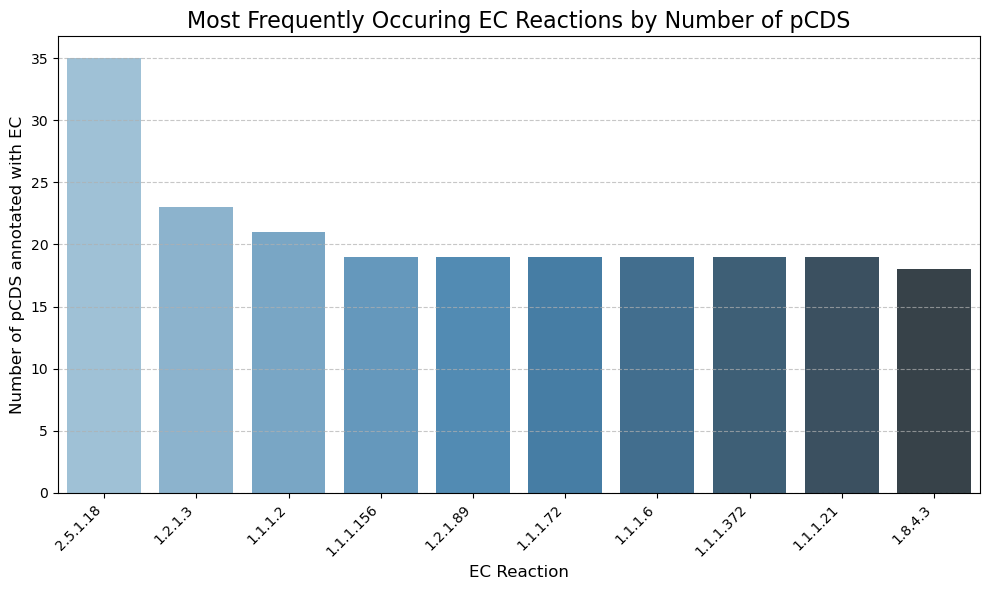

In [338]:
#first result is the number of contigs annotated with a given ec, showing top 10 ECs by number of contigs
fig, ax = plt.subplots(figsize=(10, 6))

#bar plot of this
sns.barplot(data=tripartite_tree_de_txpts_upreg_pfam_ec_df_exploded_grouped.head(10), 
            x="ec_set", 
            y="accession", 
            hue = "ec_set", 
            legend = False,
            palette="Blues_d")

# format figure
plt.title('Most Frequently Occuring EC Reactions by Number of pCDS', fontsize=16)
plt.xlabel('EC Reaction', fontsize=12)
plt.ylabel('Number of pCDS annotated with EC', fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.savefig(f"{analysis_output_path}/figures/metatranscriptome/salix_top_ecs_by_n_contig.svg")

In [340]:
#next result is this table of Salix_HiSeq_c600230_g5_i1 (most abundant) coglig annotations

most_abundant_txpt_cogligs = tripartite_tree_de_txpts_upreg_pfam_cogligs_df.loc[tripartite_tree_de_txpts_upreg_pfam_cogligs_df.accession == "Salix_HiSeq_c600230_g5_i1"].copy()
most_abundant_txpt_cogligs["ecID_split"] = most_abundant_txpt_cogligs.ecID.str.split(",")
most_abundant_txpt_cogligs["ec_grouped"] = most_abundant_txpt_cogligs.ecID_split.apply(lambda x: find_ec_ranges(sorted(x)))
most_abundant_txpt_cogligs["ec_grouped"] = most_abundant_txpt_cogligs["ec_grouped"].str.join(",")
most_abundant_txpt_cogligs[["domInt", "clName", "ec_grouped"]].to_csv(f"{analysis_output_path}/tables/salix_most_abundant_contig_cogligs.tsv", sep = "\t", index = False)

In [ ]:
print(f"""
From an input set of {tripartite_bacteria_de_txpts_upreg.accession.nunique()} CDS from Bacteria which are upregulated,
a total of {tripartite_bacteria_de_txpts_upreg_pfam_cogligs_df.accession.nunique()} predicted CDS can be annotated with putative cognate 
ligand binding potential. These correspond to {tripartite_bacteria_de_txpts_upreg_pfam_cogligs_df.clUID.nunique()} unique potential putative cognate ligands.
""")

## Targetted Searching

The paper reports hydrocarbon degradation transcripts are contributed from bacteria, not fungi or tree. We can search for EC specific annotations in a targetted way.

In [342]:
hydrocarbon_degradation_ec_list = ["1.13.11.", "1.14.11.", "1.14.12.","1.14.14.5", "1.14.14.28"]

tripartite_bacteria_de_txpts_upreg_pfam_cogligs_df_targetted = analyse_sample(tripartite_bacteria_de_txpts_upreg, n_parallel = 10, ec_list = hydrocarbon_degradation_ec_list)
tripartite_bacteria_de_txpts_upreg_pfam_ec_df_targetted = analyse_sample(tripartite_bacteria_de_txpts_upreg, n_parallel = 10, analysis_type = "ec", ec_list = hydrocarbon_degradation_ec_list)
tripartite_bacteria_de_txpts_upreg_pfam_cogligs_df_targetted_merged = tripartite_bacteria_de_txpts_upreg_pfam_cogligs_df_targetted.merge(tripartite_bacteria_de_txpts_upreg[["accession", "RealFC", "T_Meantpm"]], on = "accession")
tripartite_bacteria_de_txpts_upreg_pfam_ec_df_targetted_marged = tripartite_bacteria_de_txpts_upreg_pfam_ec_df_targetted.merge(tripartite_bacteria_de_txpts_upreg[["accession", "RealFC", "T_Meantpm"]], on = "accession")


tripartite_basidiomycota_de_txpts_upreg_pfam_cogligs_df_targetted = analyse_sample(tripartite_basidiomycota_de_txpts_upreg, n_parallel = 10, ec_list = hydrocarbon_degradation_ec_list)
tripartite_basidiomycota_de_txpts_upreg_pfam_ec_df_targetted = analyse_sample(tripartite_basidiomycota_de_txpts_upreg, n_parallel = 10, analysis_type = "ec", ec_list = hydrocarbon_degradation_ec_list)
tripartite_basidiomycota_de_txpts_upreg_pfam_cogligs_df_targetted_merged = tripartite_basidiomycota_de_txpts_upreg_pfam_cogligs_df_targetted.merge(tripartite_basidiomycota_de_txpts_upreg[["accession", "FoldChange", "T_Meantpm"]], on = "accession")
tripartite_basidiomycota_de_txpts_upreg_pfam_ec_df_targetted_marged = tripartite_basidiomycota_de_txpts_upreg_pfam_ec_df_targetted.merge(tripartite_basidiomycota_de_txpts_upreg[["accession", "FoldChange", "T_Meantpm"]], on = "accession")

tripartite_tree_de_txpts_upreg_pfam_cogligs_df_targetted = analyse_sample(tripartite_tree_de_txpts_upreg, n_parallel = 10, ec_list = hydrocarbon_degradation_ec_list)
tripartite_tree_de_txpts_upreg_pfam_ec_df_targetted = analyse_sample(tripartite_tree_de_txpts_upreg, n_parallel = 10, analysis_type = "ec", ec_list = hydrocarbon_degradation_ec_list)
tripartite_tree_de_txpts_upreg_pfam_cogligs_df_targetted_merged = tripartite_tree_de_txpts_upreg_pfam_cogligs_df_targetted.merge(tripartite_tree_de_txpts_upreg[["accession", "FoldChange", "T_Meantpm"]], on = "accession")
tripartite_tree_de_txpts_upreg_pfam_ec_df_targetted_marged = tripartite_tree_de_txpts_upreg_pfam_ec_df_targetted.merge(tripartite_tree_de_txpts_upreg[["accession", "FoldChange", "T_Meantpm"]], on = "accession")


print(f"""
Salix {tripartite_tree_de_txpts_upreg_pfam_cogligs_df_targetted.accession.nunique()} transcripts, {tripartite_tree_de_txpts_upreg_pfam_cogligs_df_targetted.clUID.nunique()} unique cogligs, {tripartite_tree_de_txpts_upreg_pfam_cogligs_df_targetted.domInt.nunique()} unique domain interactions,
Basidiomycota {tripartite_basidiomycota_de_txpts_upreg_pfam_cogligs_df_targetted.accession.nunique()} transcripts, {tripartite_basidiomycota_de_txpts_upreg_pfam_cogligs_df_targetted.clUID.nunique()} unique cogligs, {tripartite_basidiomycota_de_txpts_upreg_pfam_cogligs_df_targetted.domInt.nunique()} unique domain interactions,
Bacteria {tripartite_bacteria_de_txpts_upreg_pfam_cogligs_df_targetted.accession.nunique()} transcripts, {tripartite_bacteria_de_txpts_upreg_pfam_cogligs_df_targetted.clUID.nunique()} unique cogligs, {tripartite_bacteria_de_txpts_upreg_pfam_cogligs_df_targetted.domInt.nunique()} unique domain interactions""")


Salix 17 transcripts, 19 unique cogligs, 5 unique domain interactions,
Basidiomycota 9 transcripts, 23 unique cogligs, 8 unique domain interactions,
Bacteria 28 transcripts, 48 unique cogligs, 13 unique domain interactions


In [343]:
tripartite_tree_de_txpts_upreg_pfam_ec_df_targetted_marged_exploded = tripartite_tree_de_txpts_upreg_pfam_ec_df_targetted_marged.explode("ec_set")
tripartite_tree_de_txpts_upreg_pfam_ec_df_targetted_marged_exploded_filtered = tripartite_tree_de_txpts_upreg_pfam_ec_df_targetted_marged_exploded.loc[tripartite_tree_de_txpts_upreg_pfam_ec_df_targetted_marged_exploded.ec_set.apply(lambda x: any(x.startswith(y) for y in hydrocarbon_degradation_ec_list))]
tripartite_tree_de_txpts_upreg_pfam_ec_df_targetted_marged_exploded_filtered.groupby("ec_set").accession.nunique().sort_values(ascending = False).head(10)

ec_set
1.13.11.27    10
1.14.14.5      8
1.14.14.51     8
1.14.14.52     8
1.14.14.53     8
1.14.14.55     8
1.14.14.56     8
1.14.11.21     5
1.14.11.20     5
1.14.11.37     5
Name: accession, dtype: int64

In [344]:
tripartite_basidiomycota_de_txpts_upreg_pfam_ec_df_targetted_marged_exploded = tripartite_basidiomycota_de_txpts_upreg_pfam_ec_df_targetted_marged.explode("ec_set")
tripartite_basidiomycota_de_txpts_upreg_pfam_ec_df_targetted_marged_exploded_filtered = tripartite_basidiomycota_de_txpts_upreg_pfam_ec_df_targetted_marged_exploded.loc[tripartite_basidiomycota_de_txpts_upreg_pfam_ec_df_targetted_marged_exploded.ec_set.apply(lambda x: any(x.startswith(y) for y in hydrocarbon_degradation_ec_list))]
tripartite_basidiomycota_de_txpts_upreg_pfam_ec_df_targetted_marged_exploded_filtered.groupby("ec_set").accession.nunique().sort_values(ascending = False)

ec_set
1.14.14.55    3
1.14.14.56    3
1.13.11.41    3
1.13.11.27    3
1.14.14.52    3
1.14.14.53    3
1.14.14.5     3
1.14.14.51    3
1.13.11.48    2
1.13.11.4     2
1.13.11.24    2
1.13.11.1     1
1.13.11.23    1
1.13.11.2     1
1.13.11.35    1
1.13.11.37    1
1.13.11.39    1
1.13.11.3     1
1.13.11.8     1
1.13.11.80    1
Name: accession, dtype: int64

In [346]:
tripartite_bacteria_de_txpts_upreg_pfam_ec_df_targetted_marged_exploded = tripartite_bacteria_de_txpts_upreg_pfam_ec_df_targetted_marged.explode("ec_set")
tripartite_bacteria_de_txpts_upreg_pfam_ec_df_targetted_marged_exploded_filtered = tripartite_bacteria_de_txpts_upreg_pfam_ec_df_targetted_marged_exploded.loc[tripartite_bacteria_de_txpts_upreg_pfam_ec_df_targetted_marged_exploded.ec_set.apply(lambda x: any(x.startswith(y) for y in hydrocarbon_degradation_ec_list))]
tripartite_bacteria_de_txpts_upreg_pfam_ec_df_targetted_marged_exploded_filtered.groupby("ec_set").accession.nunique().sort_values(ascending = False).head(10)

ec_set
1.13.11.18    6
1.14.11.64    5
1.14.11.7     4
1.14.11.69    4
1.14.11.68    4
1.14.11.67    4
1.14.11.66    4
1.14.11.65    4
1.14.11.63    4
1.14.11.62    4
Name: accession, dtype: int64

## Marine Metatranscriptome

In [368]:
season_de = pd.read_csv(f"{analysis_output_path}/data/marine_metatranscriptome/season_DE.csv")
season_de_upreg = season_de.loc[(season_de.logFC >= 0.301)]
season_de_upreg_pfam = season_de_upreg.loc[season_de_upreg.Pfam != " "].copy()
season_de_upreg_pfam["domain"] = season_de_upreg_pfam["Pfam"].str.strip(";").str.strip(" ").str.split(";")
season_de_upreg_pfam["accession"] = season_de_upreg_pfam["contig"]

#logs are in base 10, so a two fold change == 0.301

In [347]:
season_de_upreg_pfam_cogligs_df = analyse_sample(season_de_upreg_pfam, n_parallel = 10)
season_de_upreg_pfam_ec_df = analyse_sample(season_de_upreg_pfam, n_parallel = 10, analysis_type = "ec")

In [351]:
top_cogligs_upreg = season_de_upreg_pfam_cogligs_df.groupby("clName")["accession"].nunique().sort_values(ascending = False).reset_index()
top_cogligs_upreg.rename(columns = {"clName": "Cognate Ligand" , "accession": "Number of Contigs"}, inplace = True)
top_cogligs_upreg.head(15).to_csv(f"{analysis_output_path}/tables/marine_top_15_cognate_ligands_upreg.csv")
top_cogligs_upreg.head(50)

,Cognate Ligand,Number of Contigs
0,ATP,194
1,ADP,192
2,dATP,141
3,HPO4(2-),116
4,Sulfate,98
5,dTTP,93
6,Diphosphate,89
7,UDP,84
8,Glycerol,81
9,Glycol,68


here we see frequent enrichment of dntp and atp binding - suggesting a roles in DNA synthesis.
curiously, we also see enrichment of platoquinone and plastoquinol binding contigs, lets get the uniprot ids to investigate taxonomy

In [373]:
plasto_contigs = season_de_upreg_pfam_cogligs_df.loc[season_de_upreg_pfam_cogligs_df.clName.isin(["Plastoquinone 8", "Plastoquinone-9", "Plastoquinol-9"])].accession.unique()
season_de_upreg_pfam.loc[season_de_upreg_pfam.accession.isin(plasto_contigs)].Accession.unique()

plast_taxonomy = pd.read_csv(f"{analysis_output_path}/data/soil_metatranscriptome/plasto_contig_taxonomy_notes.txt", sep = "," , comment = "#")
plast_taxonomy

,uniprot_accession,taxonomy
0,Q7U4Z3,Parasynechococcus marenigrum (cyanobacteria)
1,Q06473,Synechocystis sp. PCC 6803 (cyanobacteria)
2,Q3AYB8,unclassified Synechococcus (cyanobacteria)
3,Q3AV15,unclassified Synechococcus (cyanobacteria)
4,Q6H956,Synechococcus phage S-RSM2 (cyanophage)
5,Q6H952,Synechococcus phage S-WHM1 (cyanophage)
6,P31694,unclassified Nostoc (cyanobacteria)
7,Q8DIV4,Thermosynechococcus vestitus (cyanobacteria)
8,Q0QZ08,Synechococcus phage syn9 (cyanophage)
9,A5GTY4,unclassified Synechococcus (cyanobacteria)


so seems there is an upregulation of plastoquinol from cyanobacteria predominantly, but also cyanophage plasto enrichment! supports the idea that the phage are increased to terminate the bloom.

### Conclusion

In [353]:
## how many missing ec in the sifts mapping
from Bio.ExPASy import Enzyme as EEnzyme
def process_ec_records(enzyme_dat_file, enzyme_class_file):
    """
    Process EC records and generate related dataframes.

    Returns:
    ec_records_df_grouped (DataFrame): Grouped EC records dataframe.
    ec_class_descriptions (DataFrame): EC class descriptions dataframe.
    ec_subclass_descriptions (DataFrame): EC subclass descriptions dataframe.
    ec_subsubclass_descriptions (DataFrame): EC subsubclass descriptions dataframe.
    """

    with open(enzyme_dat_file) as handle:
        ec_records = EEnzyme.parse(handle)
        ec_records_list = []
        for record in ec_records: 
            ec_record_series = pd.Series(record)
            ec_records_list.append(ec_record_series)

    ec_records_df = pd.DataFrame(ec_records_list)
    ec_records_df["TRANSFER"] = ec_records_df.apply(lambda x: get_terminal_record(x["ID"], x, ec_records_df), axis = 1)
    ec_records_df["TRANSFER"] = ec_records_df["TRANSFER"].fillna(ec_records_df.ID)

    with open(enzyme_class_file, 'r') as file:
        lines = [line.strip() for line in file if re.match(r'^\d\.', line.strip())]

    ec_descriptions = []
    for line in lines:
        ec = ''.join(line[0:9]).replace(' ', '')
        description = re.findall(r'.*.-\s+(.*)', line)[0]
        ec_descriptions.append((ec, description))

    ec_descriptions_df = pd.DataFrame(ec_descriptions, columns= ["EC", "description"])
    ec_records_df_grouped = ec_records_df.groupby("TRANSFER").agg({"ID": list}).reset_index()

    ec_records_df_grouped = ec_records_df_grouped.merge(ec_records_df[["ID", "DE"]], left_on = "TRANSFER", right_on = "ID")
    ec_records_df_grouped.rename(columns = {"ID_x" : "ID"}, inplace = True)
    ec_records_df_grouped.drop(columns = ["ID_y"], inplace = True)
    ec_records_df_grouped[["class", "subclass", "subsubclass", "term"]] = ec_records_df_grouped.TRANSFER.str.split(".", expand = True)
    ec_records_df_grouped = ec_records_df_grouped.loc[ec_records_df_grouped.DE != "Deleted entry."].copy()
    
    subsubclass = ec_records_df_grouped["class"].astype("str") + "." + ec_records_df_grouped["subclass"] + "." + ec_records_df_grouped["subsubclass"] + ".-"
    subclass = ec_records_df_grouped["class"].astype("str") + "." + ec_records_df_grouped["subclass"] + ".-.-"
    ec_class = ec_records_df_grouped["class"].astype("str") + ".-.-.-"

    ec_records_df_grouped["subsubclass"] = subsubclass
    ec_records_df_grouped["subclass"] = subclass
    ec_records_df_grouped["class"] = ec_class

    ec_class_descriptions = ec_descriptions_df.loc[ec_descriptions_df.EC.str.contains("\d\.-\.-\.-$", regex = True)].copy().rename(columns = {"EC": "class","description" : "class_description"})
    ec_subclass_descriptions = ec_descriptions_df.loc[ec_descriptions_df.EC.str.contains(r"\d\.-\.-$", regex = True)].copy().rename(columns = {"EC":"subclass","description" : "subclass_description"})
    ec_subsubclass_descriptions = ec_descriptions_df.loc[ec_descriptions_df.EC.str.contains(r"\d\.-$", regex = True)].copy().rename(columns = {"EC" : "subsubclass","description" : "subsubclass_description"})

    ec_records_df_grouped = ec_records_df_grouped.merge(ec_class_descriptions, on = "class", how = "left")
    ec_records_df_grouped = ec_records_df_grouped.merge(ec_subclass_descriptions, on = "subclass", how = "left")
    ec_records_df_grouped = ec_records_df_grouped.merge(ec_subsubclass_descriptions, on = "subsubclass", how = "left")

    return ec_records_df_grouped
import re
def get_terminal_record(entry, row, df):
    entry = row.ID
    pattern = r"[\d-]+\.[\d-]+\.[\d-]+\.[\d-]+"
    while row.DE.startswith("Transferred entry: "):
        transfers = re.findall(pattern, row.DE)
        #when updating, if multiple possible transfers, selecting only first.
        row = df.loc[df.ID == transfers[0]].iloc[0]
    return row.ID

sifts_file = pd.read_csv("/raid/MattC/repos/ProCogGraphData/data_files/pdb_chain_enzyme.tsv.gz", sep = "\t", skiprows = 1)
ec_records_df_grouped = process_ec_records("/raid/MattC/repos/ProCogGraphData/data_files/enzyme.dat" , "/raid/MattC/repos/ProCogGraphData/data_files/enzclass.txt")
ec_id_nodes = ec_records_df_grouped[["TRANSFER", "DE"]].rename(columns = {"TRANSFER" : "ecID:ID(ec-id)", "DE" : "description"}).drop_duplicates()



In [354]:
sifts_file#.loc[sifts_file.EC_NUMBER.str.contains(",")]

,PDB,CHAIN,ACCESSION,EC_NUMBER
0,101m,A,P02185,?
1,102l,A,P00720,3.2.1.17
2,102m,A,P02185,?
3,103l,A,P00720,3.2.1.17
4,103m,A,P02185,?
...,...,...,...,...
876233,9xia,A,P24300,5.3.1.5
876234,9xim,A,P12851,5.3.1.5
876235,9xim,B,P12851,5.3.1.5
876236,9xim,C,P12851,5.3.1.5


In [355]:
ec_id_nodes["sub_class"] = ec_id_nodes["ecID:ID(ec-id)"].str.extract("(\d+\.\d+)\.")
ec_id_nodes.loc[ec_id_nodes["ecID:ID(ec-id)"].isin(sifts_file.EC_NUMBER.unique()) == False].sub_class.value_counts()

sub_class
1.14    391
2.4     283
1.1     273
4.2     224
2.3     181
       ... 
3.13      1
3.12      1
1.23      1
1.19      1
1.20      1
Name: count, Length: 69, dtype: int64

## Thesis Reviewer Comment

In [ ]:
#limitations of procoggraph - explore the coverage of cognate ligand space as a commment. So find all the cogligs that do not have a mapping to a ligand in a strcuture

coglig_no_match_query = """
MATCH (cl:cognateLigand)-[:IS_IN_EC]->(ec:ecID)
WHERE NOT (cl)<-[:HAS_SIMILARITY]-(:boundEntity)
RETURN cl.name, COLLECT(ec.ecID) LIMIT 20
"""


coglig_no_match_result = pd.DataFrame([dict(_) for _ in conn.query(query = coglig_no_match_query, db='neo4j')])
coglig_no_match_result["cl.name"] = coglig_no_match_result["cl.name"].str.join(",")
coglig_no_match_result.to_csv(f"{analysis_output_path}/tables/top20_unmatched_cogligs.tsv", sep = "\t")

## Paper Reviewer comment

In [ ]:
coglig_pkl = pd.read_pickle("/raid/MattC/repos/ProCogGraphData/procoggraph_20240528/get_cognate_ligands/cognate_ligands_df.pkl")

coglig_pkl_unique = coglig_pkl[["uniqueID", "ligand_db"]].drop_duplicates()

coglig_pkl_unique["db_types"] = coglig_pkl_unique['ligand_db'].apply(lambda x: set([entry.split(':')[0] for entry in x.split('|')]))
coglig_pkl_unique['db_count'] = coglig_pkl_unique['db_types'].apply(len)

from collections import Counter
from itertools import combinations

#get db co-occurences
db_pairs = []
for dbs in coglig_pkl_unique['db_types']:
    if len(dbs) > 1:
        db_pairs.extend(combinations(sorted(dbs), 2))  # Get unique pairs of databases

#count these
overlap_counts = Counter(db_pairs)

#convert counter to a dataframe
overlap_df = pd.DataFrame(overlap_counts.items(), columns=['db_pair', 'count'])
db_value_counts = coglig_pkl_unique.explode("db_types").db_types.value_counts().reset_index()

In [63]:
#get db co-occurences
db_pairs2 = []
for dbs in coglig_pkl_unique['db_types']:
    if len(dbs) > 1:
        db_pairs2.extend(combinations(sorted(dbs), 3))  # Get unique pairs of databases

#count these
overlap_counts2 = Counter(db_pairs2)

#convert counter to a dataframe
overlap_df2 = pd.DataFrame(overlap_counts2.items(), columns=['db_pair', 'count'])

In [64]:
overlap_df2

,db_pair,count
0,"(CHEBI, KEGG, Pubchem)",4703
1,"(CHEBI, KEGG, POLYMER)",45
2,"(CHEBI, POLYMER, Pubchem)",40
3,"(KEGG, POLYMER, Pubchem)",71
4,"(CHEBI, GlyTouCan, KEGG)",26
5,"(CHEBI, GlyTouCan, POLYMER)",5
6,"(CHEBI, GlyTouCan, Pubchem)",26
7,"(GlyTouCan, KEGG, POLYMER)",5
8,"(GlyTouCan, KEGG, Pubchem)",26
9,"(GlyTouCan, POLYMER, Pubchem)",5


In [48]:
print(f"""
We have a total of {coglig_pkl_unique.uniqueID.nunique()} unique cognate ligands in the dataset.
The mean number of database cross references for each of these is: {coglig_pkl_unique.db_count.mean()}
db_value_counts details the number of ligands with db references to a given db.
Overlap df details the pairwise combinations seen across the dataset.
""")


We have a total of 8589 unique cognate ligands in the dataset.
The mean number of database cross references for each of these is: 2.2457794853882875
db_value_counts details the number of ligands with db references to a given db.
Overlap df details the pairwise combinations seen across the dataset.



In [49]:
db_value_counts

db_types
CHEBI        7087
KEGG         6450
Pubchem      5393
GlyTouCan     215
POLYMER       144
Name: count, dtype: int64

In [44]:
overlap_df

,db_pair,count
0,"(CHEBI, KEGG)",5509
1,"(CHEBI, Pubchem)",4742
2,"(KEGG, Pubchem)",5031
3,"(CHEBI, POLYMER)",50
4,"(KEGG, POLYMER)",79
5,"(POLYMER, Pubchem)",71
6,"(CHEBI, GlyTouCan)",27
7,"(GlyTouCan, KEGG)",33
8,"(GlyTouCan, POLYMER)",8
9,"(GlyTouCan, Pubchem)",26


In [70]:
#they also asked us to project some drugs into the coglig t-sne: 

In [79]:
#load the drugs
common_drugs = pd.read_csv("common_drugs.csv", comment = "#")

In [80]:
common_drugs

,rank,drug_class_bnf-group,common_example,example_smiles,example_drugbank_id
0,1,Proton pump inhibitors,omeprazole,COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C,DB00338
1,2,Statins,simvastatin,[H][C@]12[C@H](C[C@@H](C)C=C1C=C[C@H](C)[C@@H]...,DB00641
2,3,Paracetamol,Paracetamol,CC(=O)NC1=CC=C(O)C=C1,DB00316
3,4,Beta‐blockers,bisoprolol,CC(C)NCC(O)COC1=CC=C(COCCOC(C)C)C=C1,DB00612
4,6,Calcium‐channel blockers,amlodipine,CCOC(=O)C1=C(COCCN)NC(C)=C(C1C1=CC=CC=C1Cl)C(=...,DB00381
5,7,H1 receptor antagonists,cyclizine,CN1CCN(CC1)C(C1=CC=CC=C1)C1=CC=CC=C1,DB01176
6,8,Aspirin,Aspirin,CC(=O)OC1=CC=CC=C1C(O)=O,DB00945
7,9,Opioids: weak/moderate,tramadol,COC1=CC=CC(=C1)C1(O)CCCCC1CN(C)C,DB00193
8,10,Opioids: strong,morphine,[H][C@@]12OC3=C(O)C=CC4=C3[C@@]11CCN(C)[C@]([H...,DB00295
9,11,Beta2 agonists,salbutamol,CC(C)(C)NCC(O)C1=CC(CO)=C(O)C=C1,DB01001


In [81]:
common_drugs["ROMol"] = common_drugs.example_smiles.apply(lambda x: pdbe_sanitise_smiles(x, return_mol = True))
common_drugs["MACCSKey"] = common_drugs.ROMol.apply(lambda x: MACCSkeys.GenMACCSKeys(x))

In [89]:
common_drugs.rename(columns = {"common_example": "name"}, inplace = True)

In [90]:
cogligs_copy = superfamily_cogligs_query_result_exploded[["coglig_name", "MACCSKey"]].drop_duplicates(subset = ["coglig_name"]).rename(columns = {"coglig_name": "name"}).copy()

In [93]:
drugs_cogligs = pd.concat([cogligs_copy, common_drugs[["name", "MACCSKey"]]])

In [94]:
tsne2 = TSNE(n_components=2, perplexity=24, max_iter=5000, random_state = 42)
tsne_result2 = tsne2.fit_transform(np.array(drugs_cogligs.MACCSKey.tolist()))

In [96]:
drugs_cogligs['t-SNE 1'] = tsne_result2[:, 0]
drugs_cogligs['t-SNE 2'] = tsne_result2[:, 1]

In [98]:
common_drugs_merged = common_drugs.merge(drugs_cogligs[["name", "t-SNE 1", "t-SNE 2"]], on = "name")

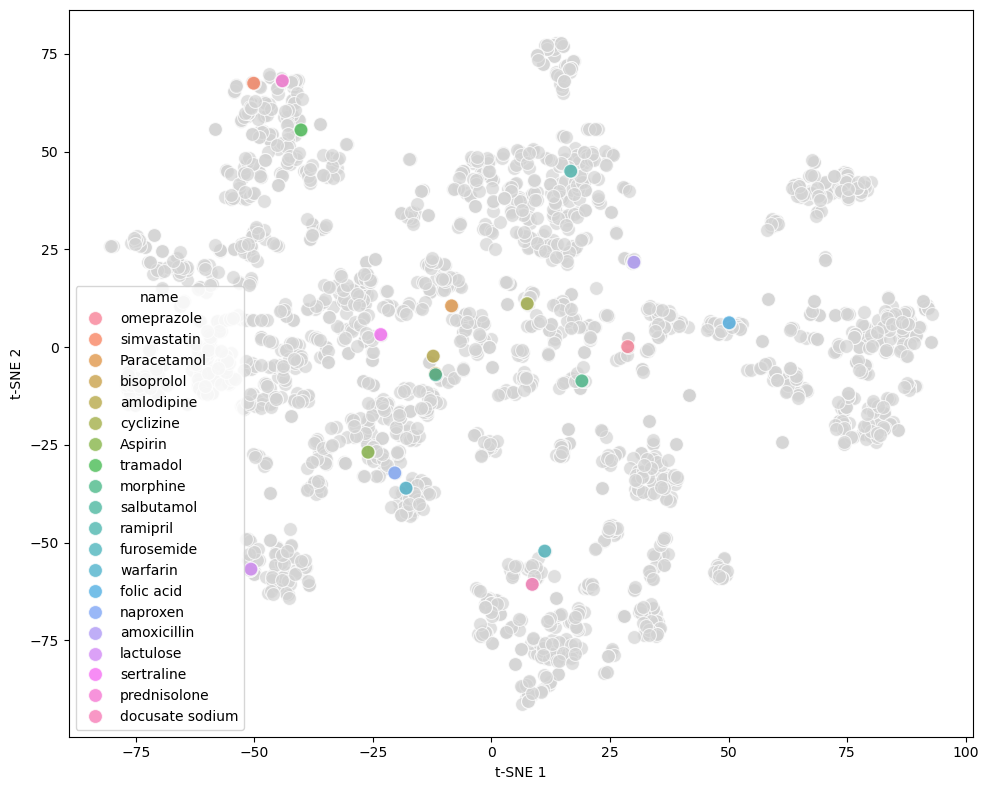

In [99]:
# Plotting PCA Results with Colors
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x='t-SNE 1', y='t-SNE 2', 
    data=drugs_cogligs,
    color = "lightgrey",
    alpha = 0.7,
    s=100
)

sns.scatterplot(
    x='t-SNE 1', y='t-SNE 2', 
    data=common_drugs_merged,
    hue = "name",
    alpha = 0.7,
    s=100
)

#plt.legend(title='Cluster #', loc='upper right', ncol=1)
#plt.title("Nucleoside Triphosphate Pyrophosphohydrolase Superfamily (3.90.79.10) Cognate Ligands")
plt.tight_layout()
#plt.savefig("3_90_79_10_ligands.svg")

## DEPRECATED 4.3.6 Enzyme Class Domain Diversity

In [ ]:
#num cogligs column is essentially the promiscuous domains query from past paper
#sns.histplot(data = superfamily_cogligs_query_mean_std_multi, x = "num_cogligs")

In [16]:
##investigating domain diversity of enzyme classes in ProCogGraph
ec_domain_diversity_query = """
MATCH (ch:cathHomologousSuperfamily)<-[:IS_IN_CATH_HOMOLOGOUS_SUPERFAMILY]-(d:cathDomain)-[int:INTERACTS_WITH_LIGAND]->(be:boundEntity)-[sim:HAS_SIMILARITY]->(cl:cognateLigand)-[:IS_IN_EC]->(ec:ecID) 
WHERE ec.ecID in be.ecList AND int.interactionMode <> "minor" AND sim.parityScore >= 0.4 AND sim.bestCognate = "Y"  
RETURN ec.ecID, collect(DISTINCT(ch.cathHomologousSuperfamily)) LIMIT 100"""

ec_domain_diversity_query_result = pd.DataFrame(conn.query(query = ec_domain_diversity_query, db='graph.db'), columns = ["ec_id","cath_homologous_superfamilies"])

In [17]:
ec_domain_diversity_query_result

,ec_id,cath_homologous_superfamilies
0,2.4.1.1,"[3.40.50.2000, 3.20.20.80, 2.115.10.20, 3.90.5..."
1,2.4.1.11,"[3.40.50.2000, 3.20.20.80, 2.115.10.20, 3.90.5..."
2,2.4.1.32,"[3.40.50.2000, 3.90.550.10, 3.40.50.11340, 3.4..."
3,5.1.3.14,[3.40.50.2000]
4,2.4.1.21,"[3.40.50.2000, 3.20.20.80, 2.115.10.20, 3.90.5..."
...,...,...
95,2.4.1.309,"[3.40.50.2000, 3.90.550.10]"
96,2.4.1.306,"[3.40.50.2000, 3.90.550.10, 3.90.550.20]"
97,2.4.1.305,"[3.40.50.2000, 3.90.550.10]"
98,2.4.1.304,"[3.40.50.2000, 3.90.550.10]"


In [ ]:
ecs_cath_homologous_superfamilies_query = """
MATCH (ch:cathHomologousSuperfamily)<-[:IS_IN_CATH_HOMOLOGOUS_SUPERFAMILY]-(d:cathDomain)-[int:INTERACTS_WITH_LIGAND]->(be:boundEntity)-[sim:HAS_SIMILARITY]->(cl:cognateLigand)-[:IS_IN_EC]->(ec:ecID)-[:IS_IN_SUBSUBCLASS]->(ecss:ecSubSubClass)
WHERE ec.ecID in be.ecList AND int.interactionMode <> "minor" AND sim.parityScore >= 0.4 AND sim.bestCognate = "Y"
RETURN ecss.ecID, collect(DISTINCT(ch.cathHomologousSuperfamily))"""

ecs_cath_homologous_superfamilies_query_result = pd.DataFrame(conn.query(query = ecs_cath_homologous_superfamilies_query, db='graph.db'), columns = ["ecss_id", "cath_homologous_superfamilies"])
ecs_cath_homologous_superfamilies_query_result["num_superfams"] = ecs_cath_homologous_superfamilies_query_result.cath_homologous_superfamilies.str.len()

ecs_cath_homologous_superfamilies_query_result_top20 = ecs_cath_homologous_superfamilies_query_result.sort_values("num_superfams", ascending = False).head(20)
ecs_cath_homologous_superfamilies_query_result_top20.to_csv("top20_esc_cath_homol_sup.csv")

#82 distinct cogligs - and the different various combos can be discussed and investigated
domain_contexts_ec277_query = """
MATCH (ecss:ecSubSubClass {ecID: "2.7.7.-"})<-[:IS_IN_SUBSUBCLASS]-(ec:ecID)<-[:IS_IN_EC]-(cl:cognateLigand)<-[sim:HAS_SIMILARITY]-(be:boundEntity)<-[int:INTERACTS_WITH_LIGAND]-(d:cathDomain)-[:IS_IN_CATH_HOMOLOGOUS_SUPERFAMILY]->(ch:cathHomologousSuperfamily)
WHERE ec.ecID in be.ecList AND int.interactionMode <> "minor" AND sim.parityScore >= 0.4 AND sim.bestCognate = "Y"
WITH COLLECT(DISTINCT(ec.ecID)) as ec_id, cl.uniqueID + ":" + cl.name[0] as clUID, be.hetCode + ":" + be.uniqueID as beUID, ch.cathHomologousSuperfamily + ":" + int.interactionMode as domIntBE
WITH clUID, beUID, apoc.coll.sort(COLLECT(DISTINCT(domIntBE))) as domIntsPerBE
RETURN clUID, COLLECT(DISTINCT(domIntsPerBE))
"""

domain_contexts_ec277_query_result =  pd.DataFrame(conn.query(query = domain_contexts_ec277_query, db='graph.db'), columns = ["clUID", "domain_contexts"])

domain_contexts_ec277_query_result["num_domain_contexts"] = domain_contexts_ec277_query_result.domain_contexts.str.len()

#we observe 187 unique domain contexts for 82 cognate ligands within this enzyme class.
domain_contexts_ec277_query_result.explode("domain_contexts").domain_contexts.str.join(",").nunique()

#these are the top cogligs for ec 2.7.7.- by the number of unique domain contexts present. i.e. 2.7.7.- is the most promiscuous enzyme sub class in terms of domain combination, and within this diphosphate is the cognate ligand generating this diversity
#maybe this gets interesting for other groups?
#what do we biologically say about this. For Nucleotidyltransferases, it is unsurprising to see much diversity is due to the binding of different nucleotides.
#find the ones with the most chemically distinct would be interesting.
domain_contexts_ec277_query_result_top20 = domain_contexts_ec277_query_result.sort_values("num_domain_contexts", ascending = False).head(20)
domain_contexts_ec277_query_result_top20.to_csv("domain_contexts_ec277_query_result_top20.csv")

In [25]:
#we can also open up the number of ec matches to talk about those groupings.

In [50]:
##investigating the types of combinations that are seen in partner interactions

partner_interaction_contexts_query = """MATCH (cl:cognateLigand)<-[sim:HAS_SIMILARITY]-(be:boundEntity)<-[int:INTERACTS_WITH_LIGAND]-(d:cathDomain)-[:IS_IN_CATH_HOMOLOGOUS_SUPERFAMILY]->(ch:cathHomologousSuperfamily)
WHERE int.interactionMode in ["partner", "major_partner"] AND sim.parityScore >= 0.4 AND sim.bestCognate = "Y"
WITH cl.uniqueID + ":" + cl.name[0] as clUID, be.hetCode + ":" + be.uniqueID as beUID, ch.cathHomologousSuperfamily + ":" + int.interactionMode as domIntBE
RETURN beUID, COLLECT(DISTINCT(clUID)) as clUIDs, apoc.coll.sort(COLLECT(DISTINCT(domIntBE))) as domIntsPerBE"""

partner_interaction_contexts_query_result = pd.DataFrame(conn.query(query = partner_interaction_contexts_query, db='graph.db'), columns = ["beUID", "clUIDs", "domIntsPerBE"])

In [51]:
partner_interaction_contexts_query_result_domints = partner_interaction_contexts_query_result.domIntsPerBE.explode().value_counts().sort_values(ascending = False).reset_index()

In [52]:
print(f"""
Rossman topology domains provide {partner_interaction_contexts_query_result_domints.loc[partner_interaction_contexts_query_result_domints.domIntsPerBE.str.startswith("3.40.50.")]["count"].sum() / partner_interaction_contexts_query_result_domints["count"].sum()} % of all partner domain interactions
""")


Rossman topology domains provide 0.24664971988449863 % of all partner domain interactions



In [65]:
superfam_distinct_ecs_query = """
MATCH (ch:cathHomologousSuperfamily {cathHomologousSuperfamily: $superfamily})<-[:IS_IN_CATH_HOMOLOGOUS_SUPERFAMILY]-(cd:cathDomain)-[:IS_IN_PROTEIN_CHAIN]->(pc:proteinChain)-[:IS_IN_EC]->(ec:ecID)-[:IS_IN_SUBSUBCLASS]->(ecs:ecSubSubClass) 
RETURN ecs.ecID as ec_subsubclass, ecs.description as ec_subsubclass_description, COUNT(DISTINCT(ec.ecID)) as num_ecs 
ORDER BY num_ecs DESC"""

superfam_3_90_79_10_distinct_ecs_query_result = pd.DataFrame(conn.query(query = superfam_distinct_ecs_query, db='graph.db', superfamily = "3.90.79.10"), columns = ["ec_subsubclass", "description", "num_ecs"])
print(superfam_3_90_79_10_distinct_ecs_query_result.num_ecs.sum())

1025


In [ ]:
#now visualising this as sunburst charts

fig = px.sunburst(
    ligand_all,
    path=['type', 'group'],
    values='be_count',
    #maxdepth = 1
)
fig.update_traces(textinfo="label+percent root")
fig.update_traces(branchvalues="total")
#fig.show()

# plotly graph_objects figure
fig2 =go.Figure(go.Sunburst(
    labels=fig['data'][0]['labels'].tolist(),
    parents=fig['data'][0]['parents'].tolist(),
    values=fig['data'][0]['values'].tolist(),
    ids=fig['data'][0]['ids'].tolist(),
    branchvalues= "total",
    textinfo = "label+percent parent",
    level = "notCofactor"
))

#fig2.show()

# plotly graph_objects figure
fig3 =go.Figure(go.Sunburst(
    labels=fig['data'][0]['labels'].tolist(),
    parents=fig['data'][0]['parents'].tolist(),
    values=fig['data'][0]['values'].tolist(),
    ids=fig['data'][0]['ids'].tolist(),
    branchvalues= "total",
    textinfo = "label+percent parent",
    level = "cofactor"
))

#fig3.show()

pio.write_image(fig, 'perfect_matches_raw.svg')

fig_10_cofactors = px.sunburst(
    ligand_all_10.loc[ligand_all_10.type.isin(["cofactor"])],
    path=['type', 'name'],
    values='be_count',
    #maxdepth = 1
)
fig_10_cofactors.update_traces(textinfo="label+percent root")
fig_10_cofactors.update_traces(branchvalues="total")
#fig.show()

pio.write_image(fig_10_cofactors, 'perfect_matches_cofactors_top10.svg')

fig_10_notcofactors = px.sunburst(
    ligand_all_10.loc[ligand_all_10.type.isin(["notCofactor"])],
    path=['type', 'name'],
    values='be_count',
    #maxdepth = 1
)
fig_10_notcofactors.update_traces(textinfo="label+percent root")
fig_10_notcofactors.update_traces(branchvalues="total")
#fig.show()

pio.write_image(fig_10_notcofactors, 'perfect_matches_notcofactors_top10.svg')

In [ ]:
partial_ec_with_exact_ec_match_query = """
MATCH (ec:ecID)-[:IS_IN_EC]-(cl:cognateLigand)<-[sim:HAS_SIMILARITY]-(be:boundEntity)<-[:INTERACTS_WITH_LIGAND]-(d:cathDomain)-[:IS_IN_PROTEIN_CHAIN]->(pc:proteinChain {partialEC : "True"})-[:IS_IN_PDB]->(a:entry)
WHERE sim.parityScore >= 0.4 AND sim.bestCognate = "Y" 
WITH cl.name[0] as cl_name, sim.parityScore as score, be.hetCode as beHetCode, pc, COLLECT(DISTINCT(ec.ecID)) as coglig_ecs
WITH COLLECT(DISTINCT(cl_name)) as combined_cl_names, COLLECT(score) as combined_parity, COLLECT(DISTINCT(beHetCode)) as combined_be_hetcodes, apoc.coll.flatten(COLLECT(coglig_ecs)) as combined_coglig_ecs, pc
WITH combined_cl_names, combined_parity, combined_be_hetcodes, [id in pc.ecList WHERE id in combined_coglig_ecs] as pc_matched_ecs, pc, combined_coglig_ecs WHERE SIZE(pc_matched_ecs) = 1
RETURN pc.pdbProteinChain, pc.originalEC, combined_cl_names, combined_parity, combined_be_hetcodes, pc_matched_ecs, combined_coglig_ecs
"""

partial_ec_with_exact_ec_match_query_result =  pd.DataFrame(conn.query(query = partial_ec_with_exact_ec_match_query, db='neo4j'), columns = ["pdbProteinchain","originalEC", "combined_cl_names", "combined_scores", "combined_be_hetcodes", "pc_matched_ecs", "combined_coglig_ecs"])
partial_ec_with_exact_ec_match_query_result["originalEC_split"] = partial_ec_with_exact_ec_match_query_result["originalEC"].str.split(",")

partial_ec_with_exact_ec_match_query_result_of_interest = partial_ec_with_exact_ec_match_query_result.loc[~partial_ec_with_exact_ec_match_query_result.apply(lambda x: any([y in x.originalEC_split for y in x.pc_matched_ecs]), axis = 1 )]
partial_ec_with_exact_ec_match_query_result_of_interest.loc[(partial_ec_with_exact_ec_match_query_result_of_interest["combined_scores"].apply(lambda x: any(y == 1 for y in x)))].pdbProteinchain.nunique() ##this is 359

partial_ec_with_exact_ec_match_query_perfect_score = """
MATCH (ec:ecID)-[:IS_IN_EC]-(cl:cognateLigand)<-[sim:HAS_SIMILARITY]-(be:boundEntity)<-[:INTERACTS_WITH_LIGAND]-(d:cathDomain)-[:IS_IN_PROTEIN_CHAIN]->(pc:proteinChain {partialEC : "True"})-[:IS_IN_PDB]->(a:entry)
WHERE sim.parityScore = 1 AND sim.bestCognate = "Y" 
WITH cl.name[0] as cl_name, sim.parityScore as score, be.hetCode as beHetCode, pc, COLLECT(DISTINCT(ec.ecID)) as coglig_ecs
WITH COLLECT(DISTINCT(cl_name)) as combined_cl_names, COLLECT(score) as combined_parity, COLLECT(DISTINCT(beHetCode)) as combined_be_hetcodes, apoc.coll.flatten(COLLECT(coglig_ecs)) as combined_coglig_ecs, pc
WITH combined_cl_names, combined_parity, combined_be_hetcodes, [id in pc.ecList WHERE id in combined_coglig_ecs] as pc_matched_ecs, pc, combined_coglig_ecs WHERE SIZE(pc_matched_ecs) = 1
RETURN pc.pdbProteinChain, pc.originalEC, combined_cl_names, combined_parity, combined_be_hetcodes, pc_matched_ecs, combined_coglig_ecs
"""

partial_ec_protein_chains_query_result = pd.DataFrame(conn.query(query = partial_ec_protein_chains_query, db='graph.db'), columns = ["num_pdbs","num_chains", "type"])
partial_ec_with_exact_ec_match_query_perfect_score_result_of_interest = partial_ec_with_exact_ec_match_query_perfect_score_result.loc[~partial_ec_with_exact_ec_match_query_perfect_score_result.apply(lambda x: any([y in x.originalEC_split for y in x.pc_matched_ecs]), axis = 1 )]
partial_ec_with_exact_ec_match_query_perfect_score_result_of_interest.pdbProteinchain.nunique() ##this is 540
